In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import geopandas as gpd
import pandas as pd
import xarray as xr
import atlite
import PySAM.Pvwattsv8 as pv
from atlite.gis import ExclusionContainer

# Atlite Solar PV Potential for REDZ 2017 to 2019

### Load data

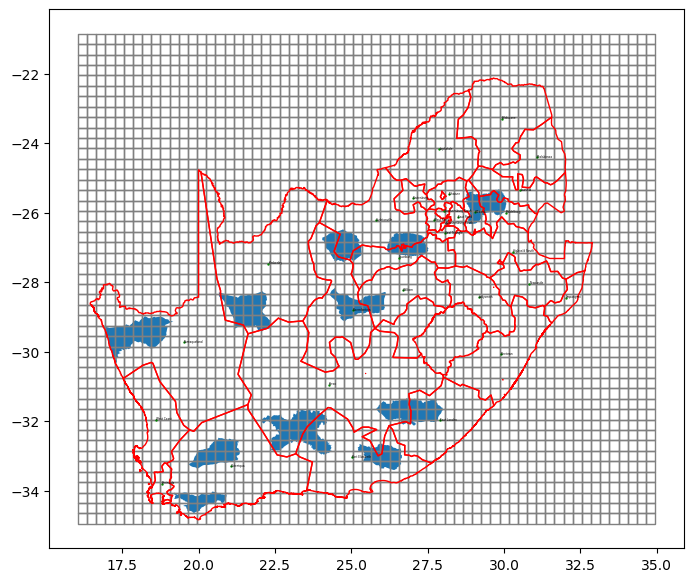

In [2]:
# Load REDZs regions
shapefile_1 = gpd.read_file('../data/bundle/Phase1_REDZs/REDZs.shp')
shapefile_2 = gpd.read_file('../data/bundle/Phase2_REDZs/PHASE 2_REDZs.shp')
shapefile_1_transformed = shapefile_1.to_crs('EPSG:4326')
shapefile_2_transformed = shapefile_2.to_crs('EPSG:4326')

combined_shapefile = gpd.GeoDataFrame(pd.concat([shapefile_1_transformed, shapefile_2_transformed], ignore_index=True))
combined_shapefile = combined_shapefile.set_index('Name')
# Load cutout for entire RSA region
cutout = atlite.Cutout(
    path="../cutouts/RSA-2017_20-era5.nc",
    chunks={"time": 100},
)
cutout.data = cutout.data.sel(time='2017')
# Visualise REDZs and RSA cutout
plt.rc("figure", figsize=[10, 7])
fig, ax = plt.subplots()
combined_shapefile.plot(ax=ax)
cutout.grid.plot(ax=ax, edgecolor="grey", color="None")

supply_30 = gpd.read_file('../data/bundle/supply_regions/30-supply.shp')
supply_30.crs = 'EPSG:4326'
supply_30.plot(ax=ax, edgecolor="red", color="None")

# Label each region within the shapes
for idx, row in supply_30.iterrows():
    centroid = row['geometry'].centroid
    if row['Name'] == 'Johannesburg South':
        ax.scatter(centroid.x, centroid.y, color='k', s=0.1)
    else:
        ax.scatter(centroid.x, centroid.y, color='green', s=0.5)    

    plt.annotate(text=row['Name'], 
                 xy=(centroid.x, centroid.y), 
                 #xytext=(3, 3), 
                 #textcoords="offset points",
                 fontsize=2)
plt.savefig('img.png', bbox_inches='tight', pad_inches=0, dpi=300)

plt.show()

### Exclude cells within REDZs which are inelligible

In [31]:
landuse = '../data/bundle/landuse_without_protected_conservation.tiff'
excluder = ExclusionContainer()
excluder.add_raster(landuse)

availability_matrix = cutout.availabilitymatrix(combined_shapefile,excluder=excluder,nprocesses=3)    

Compute availability matrix: 100%|██████████| 11/11 [00:18<00:00,  1.69s/ gridcells]


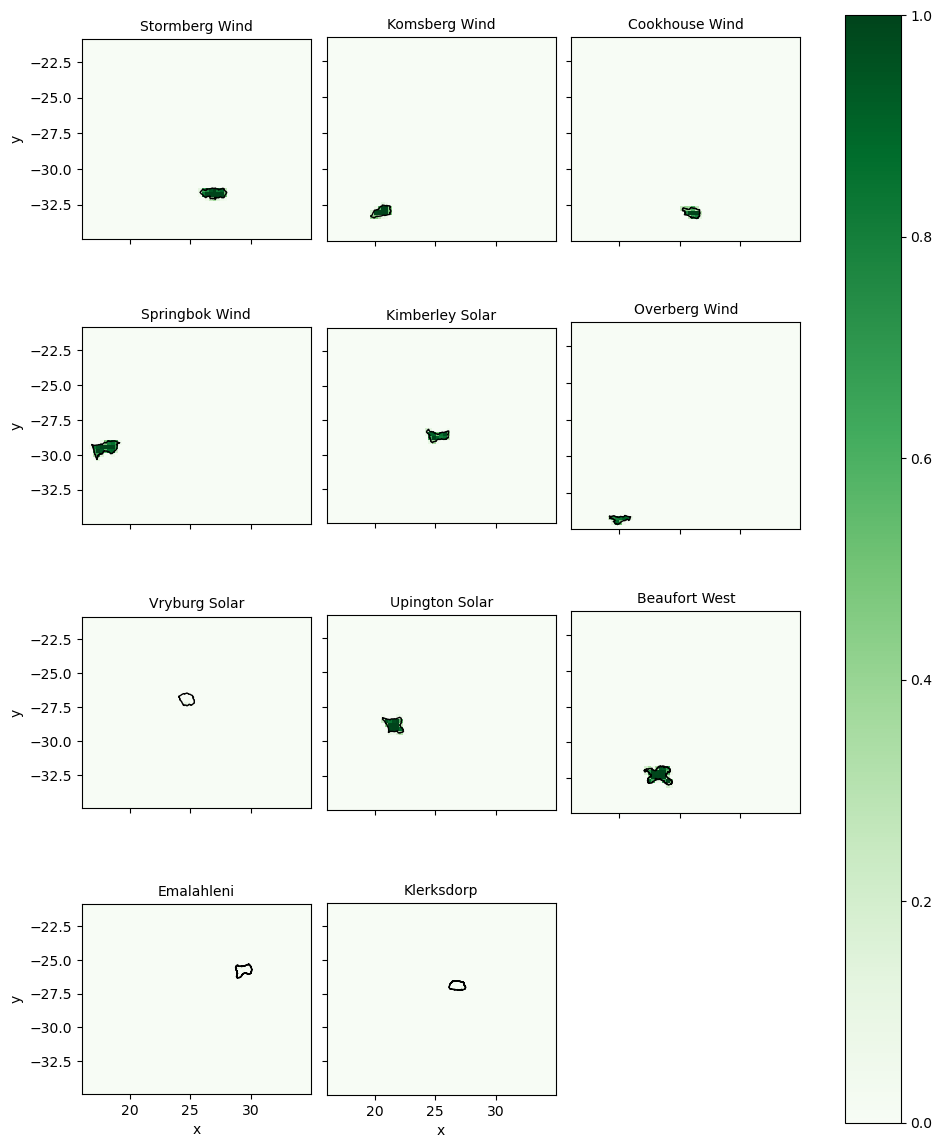

In [32]:
# Visualise available land
fg = availability_matrix.plot(row="Name", col_wrap=3, cmap="Greens")
fg.set_titles("{value}")
for i, c in enumerate(combined_shapefile.index):
    combined_shapefile.loc[[c]].plot(ax=fg.axs.flatten()[i], edgecolor="k", color="None")

In [33]:
# Calculate capacities per REDZs
#cap_per_sqkm = 1.7 # value from pypsa-eur
#area = cutout.grid.set_index(["y", "x"]).to_crs(3035).area / 1e6
#area = xr.DataArray(area, dims=("spatial"))
#capacity_matrix = availability_matrix.stack(spatial=["y", "x"]) * area * cap_per_sqkm
# Set available land to 1
#ones_matrix = np.ones_like(capacity_matrix)

pv_sat = cutout.pv(    
    panel="CSi",
    #matrix=ones_matrix,
    shapes=combined_shapefile,
    tracking="horizontal",
    per_unit=True, 
    orientation={"slope": 0.0, "azimuth": 0},
)

pv_ft = cutout.pv(    
    panel="CSi",
    #matrix=ones_matrix,
    shapes=combined_shapefile,
    tracking=None,
    per_unit=True, 
    orientation="latitude_optimal", # or {"slope": 0.0, "azimuth": 0},
)

[########################################] | 100% Completed | 410.71 s
[########################################] | 100% Completed | 425.84 s


In [34]:
pv_sat.sel(Name='Kimberley Solar').values.mean()

0.273309639562281

In [35]:
pv_ft.sel(Name='Kimberley Solar').values.mean()

0.2109645124451372

In [8]:
# fig, axes = plt.subplots(nrows=11, ncols=1, figsize=(10, 40))

# for idx, ax in zip(combined_shapefile.index, axes):
#     data_1 = pv_sat.sel(Name=idx).to_pandas()
#     data_1.plot(ax=ax,color="r",label='Single Axis')

#     data_2 = pv_ft.sel(Name=idx).to_pandas()
#     data_2.plot(ax=ax,color="b",label='Fixed Tilt')


#     ax.set_ylabel("p.u.")
#     ax.set_title(f"REDZs: {idx}")
#     ax.legend()

# plt.tight_layout()
# plt.show()



# PySAM


In [9]:
# import pandas as pd
# import geopandas as gpd
# import numpy as np
# import xarray as xr
# from shapely.geometry import Point
# from dask import delayed, compute


# def extract_solar(cutout, cell):
#     """
    
#     """
#     pv_inputs ={
# 		"system_capacity" : 1*1.2, #System size (DC nameplate) [kW]
# 		"module_type" : 1, # Module type [0/1/2]. Standard,Premium,Thin film
# 		"dc_ac_ratio" : 1.2,
# 		"bifaciality" : 0, # Module bifaciality factor [0 or ~0.65]
# 		"array_type" : 2, # Array type [0/1/2/3/4] fixed open rack,fixed roof mount,1-axis tracking,1-axis backtracking,2-axis tracking
# 		"azimuth" : 0, # Azimuth angle [deg]
# 		"gcr" : 0.3, # Ground coverage ratio [0..1]
# 		"soiling" : [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0],
# 		"losses" : 7, # Other DC losses [%]
# 		"en_snowloss" : 0, # Enable snow loss model [0/1]
# 		"inv_eff" : 95, # Inverter efficiency at rated power [%]
# 		"batt_simple_enable" : 0,# Enable Battery [0/1]
#         'tilt': 0, #Tilt angle [deg]
# 	}
#     selected_data = cutout.data.sel(x=cutout.grid.loc[cell,'x'], 
#                                     y=cutout.grid.loc[cell,'y'], 
#                                     method='nearest')
#     dn = selected_data['influx_direct'].values.tolist()
#     dh = selected_data['influx_diffuse'].values.tolist()
#     tdry = (selected_data['temperature'].values-273.15).tolist()
#     elev = (selected_data['height'].values).tolist()

#     model = pv.new()
#     for k, v in pv_inputs.items():
#         if k != 'number_inputs':
#             setattr(model.SystemDesign, k, v)
#     model.AdjustmentFactors.constant = 0

#     dates = pd.date_range('2017-01-01 00:00', '2017-12-31 23:00', freq='H')
#     wspd = [0]*len(dates)
#     year = list(dates.year)
#     month = list(dates.month)
#     day = list(dates.day)
#     hour = list(dates.hour)
#     minute = list(dates.minute)

#     model.SolarResource.assign(
#         {
#             'solar_resource_data':{
#                 'dn':dn,
#                 'df':dh,
#                 'tdry':tdry,
#                 'wspd':wspd,
#                 'lat':cutout.grid.loc[cell,'y'],
#                 'lon':cutout.grid.loc[cell,'x'],
#                 'tz':2,
#                 'elev':elev,
#                 'year':year,
#                 'month':month,
#                 'day':day,
#                 'hour':hour,
#                 'minute':minute,
#                 'albedo':0.2,
#                 "use_wf_albedo":0,
#                 }
#         }
#     )
#     model.execute()
#     ac_output = model.Outputs.ac
 
#     return np.array(ac_output)

# def process_geometry(cutout, geometry, geometry_name):
#     """
    
#     """
#     # Generate time range for the year
#     times = pd.date_range(start='2017-01-01', end='2017-12-31 23:00', freq='H')
#     gdf = gpd.GeoDataFrame(cutout.grid, 
#                            geometry=[Point(xy) for xy in zip(cutout.grid.x, cutout.grid.y)])

#     # Find points within the geometry
#     within_geometry = gdf[gdf.geometry.within(geometry)]
#     latitudes = np.array(sorted(set(within_geometry['y'])))
#     longitudes = np.array(sorted(set(within_geometry['x']))) 

#     #Save results in an xarray
#     ac_annual_output = xr.DataArray(
#         0, 
#         coords=[times, latitudes, longitudes],
#         dims=["time", "latitude", "longitude"]
#     )

#     for lat in latitudes:
#         for long in longitudes:
#             matching_cells = within_geometry.index[(within_geometry.x == long) & (within_geometry.y == lat)]
#             if len(matching_cells) > 0:
#                 cell = matching_cells[0]
#                 ac_output = extract_solar(cutout, cell)  # Direct call
#                 ac_annual_output.loc[:, lat, long] = ac_output
#     return geometry_name, ac_annual_output


# def process_shapefile(cutout, shapefile_path,shapefile_key):
#     """
#     Process a single shapefile to generate hourly unitised solar profiles for each 
#     geometry defined in the shapefile.

#     This function reads a shapefile, applies land use exclusions using atlite, and then 
#     iterates over each geometry within the shapefile. For each geometry, it extracts solar 
#     data based on the geographic area defined by that geometry and compiles the results.

    
#     """
#     # Read the shapefile and convert its coordinate reference system to EPSG:4326 for latitude
#     # and longitude calculations.
#     shape_data = gpd.read_file(shapefile_path).to_crs('EPSG:4326')

#     results = {}

#     has_name = 'Name' in shape_data.columns
#     has_corridor = 'Corridor' in shape_data.columns

#     # Iterate over each geometry in the shapefile.
#     for i, row in shape_data.iterrows():
#         if has_name and pd.notnull(row['Name']) and row['Name'] != '':
#             geometry_name = f"{shapefile_key}_{row['Name']}"
#         elif has_corridor and pd.notnull(row['Corridor']) and row['Corridor'] != '':
#             geometry_name = f"{shapefile_key}_{row['Corridor']}"
#         else:
#             geometry_name = f"{shapefile_key}_{i}"

#         # Process the geometry to extract solar data and add the results to the dictionary.
#         geometry_name, ac_annual_output  = process_geometry(cutout, 
#                                                             row.geometry,
#                                                             geometry_name)
#         results[geometry_name] = ac_annual_output
#     return results

# def process_all_shapefiles(cutout, shapefile_dict):
#     """
#     Process multiple shape files to generate hourly unitised solar profiles for all 
#     regions within the shape files.

#     Parameters:
#     - cutout: atlite cutout containing the ERA 5 meteorological data for the RSA region.
#     - shapefile_dict: dictionary containing the shapefile keys and path to the shapefile. 

#     Returns:
#     - all_results: dictionary containing the shapefile key and the hourly unitised solar profiles

#     """
#     all_results = {}
#     for shapefile_key, shapefile_path in shapefile_dict.items():
#         shapefile_results = process_shapefile(cutout, shapefile_path, shapefile_key)
#         all_results[shapefile_key] = shapefile_results
     
#     return all_results

In [10]:
# shapefile_dict = {
#     'redz_1': '../data/bundle/Phase1_REDZs/REDZs.shp',
#     'redz_2': '../data/bundle/Phase2_REDZs/PHASE 2_REDZs.shp',
#     #'power_corridor': '../data/bundle/Power_corridors/Power_corridors.shp',
#     #'11_supply': '../data/bundle/supply_regions/11-supply.shp',
#     #'30_supply': '../data/bundle/supply_regions/30-supply.shp'
# }

# all_geometry_results = process_all_shapefiles(cutout, shapefile_dict)

# for shapefile_key, geometries in all_geometry_results.items():
#     for geometry_name, data_array in geometries.items():
#         filename = f"{geometry_name}.nc"
#         if isinstance(data_array, xr.DataArray):
#             data_array.to_netcdf(filename)
#         else:
#             print(f"Unexpected format for {geometry_name}: {type(data_array)}")


In [11]:
# import pandas as pd
# import geopandas as gpd
# import numpy as np
# import xarray as xr
# from shapely.geometry import Point
# from dask import delayed, compute


# def extract_solar(cutout, cell):
#     """
    
#     """

#     pv_inputs ={
# 		"system_capacity" : 1*1.2, #System size (DC nameplate) [kW]
# 		"module_type" : 1, # Module type [0/1/2]. Standard,Premium,Thin film
# 		"dc_ac_ratio" : 1.2,
# 		"bifaciality" : 0, # Module bifaciality factor [0 or ~0.65]
# 		"array_type" : 2, # Array type [0/1/2/3/4] fixed open rack,fixed roof mount,1-axis tracking,1-axis backtracking,2-axis tracking
# 		"azimuth" : 0, # Azimuth angle [deg]
# 		"gcr" : 0.3, # Ground coverage ratio [0..1]
# 		"soiling" : [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0],
# 		"losses" : 7, # Other DC losses [%]
# 		"en_snowloss" : 0, # Enable snow loss model [0/1]
# 		"inv_eff" : 95, # Inverter efficiency at rated power [%]
# 		"batt_simple_enable" : 0,# Enable Battery [0/1]
#         'tilt': 0, #Tilt angle [deg]
# 	}
#     selected_data = cutout.data.sel(x=cutout.grid.loc[cell,'x'], 
#                                     y=cutout.grid.loc[cell,'y'], 
#                                     method='nearest')
#     dn = selected_data['influx_direct'].values.tolist()
#     dh = selected_data['influx_diffuse'].values.tolist()
#     tdry = (selected_data['temperature'].values-273.15).tolist()
#     elev = (selected_data['height'].values).tolist()

#     model = pv.new()
#     for k, v in pv_inputs.items():
#         if k != 'number_inputs':
#             setattr(model.SystemDesign, k, v)
#     model.AdjustmentFactors.constant = 0

#     dates = pd.date_range('2017-01-01 00:00', '2017-12-31 23:00', freq='H')
#     wspd = [0]*len(dates)
#     year = list(dates.year)
#     month = list(dates.month)
#     day = list(dates.day)
#     hour = list(dates.hour)
#     minute = list(dates.minute)

#     model.SolarResource.assign(
#         {
#             'solar_resource_data':{
#                 'dn':dn,
#                 'df':dh,
#                 'tdry':tdry,
#                 'wspd':wspd,
#                 'lat':cutout.grid.loc[cell,'y'],
#                 'lon':cutout.grid.loc[cell,'x'],
#                 'tz':2,
#                 'elev':elev,#100,
#                 'year':year,
#                 'month':month,
#                 'day':day,
#                 'hour':hour,
#                 'minute':minute,
#                 'albedo':0.2,
#                 "use_wf_albedo":0,
#                 }
#         }
#     )
#     model.execute()
#     ac_output = model.Outputs.ac
#     # availability = availability.sel(x=cutout.grid.loc[cell,'x'],
#     #                                 y=cutout.grid.loc[cell,'y'],
#     #                                 method='nearest').values
#     return ac_output #np.array(ac_output)

# def process_geometry(cutout, geometry, geometry_name):
#     """
    
#     """
#     # Generate time range for the year
#     times = pd.date_range(start='2017-01-01', end='2017-12-31 23:00', freq='H')
#     gdf = gpd.GeoDataFrame(cutout.grid, 
#                            geometry=[Point(xy) for xy in zip(cutout.grid.x, cutout.grid.y)])

#     # Find points within the geometry
#     within_geometry = gdf[gdf.geometry.within(geometry)]
#     latitudes = np.array(sorted(set(within_geometry['y'])))
#     longitudes = np.array(sorted(set(within_geometry['x']))) 
#     print(f"Processing {len(latitudes) * len(longitudes)} lat-long pairs")

#     #Save results in an xarray
#     ac_annual_output = xr.DataArray(
#         0, 
#         coords=[times, latitudes, longitudes],
#         dims=["time", "latitude", "longitude"]
#     )

#     delayed_results = []
#     for lat in latitudes:
#             for long in longitudes:
#                 matching_cells = within_geometry.index[(within_geometry.x == long) & (within_geometry.y == lat)]
#                 if len(matching_cells) > 0:
#                     cell = matching_cells[0]
#                     ac_output = delayed(extract_solar)(cutout, cell)
#                     delayed_results.append(ac_output)

#     computed_results = compute(*delayed_results)
#     print(f"Total number of results in computed_results: {len(computed_results)}")

#     # print('computed_results')
#     # print(len(computed_results))
#     # Assign computed results to the DataArray
#     i = 0
#     for lat in latitudes:
#         for long in longitudes:
#             if ((within_geometry.x == long) & (within_geometry.y == lat)).any():
#                 ac_annual_output.loc[:, lat, long] = computed_results[i]
#                 i += 1
#     return geometry_name, delayed_results

# def process_shapefile(cutout, shapefile_path,shapefile_key):
#     """
#     Process a single shapefile to generate hourly unitised solar profiles for each 
#     geometry defined in the shapefile.

#     This function reads a shapefile, applies land use exclusions using atlite, and then 
#     iterates over each geometry within the shapefile. For each geometry, it extracts solar 
#     data based on the geographic area defined by that geometry and compiles the results.

    
#     """
#     # Read the shapefile and convert its coordinate reference system to EPSG:4326 for latitude
#     # and longitude calculations.
#     shape_data = gpd.read_file(shapefile_path).to_crs('EPSG:4326')
    
#     # Prepare the exclusion raster based on land use data.
#     # landuse = '../data/bundle/landuse_without_protected_conservation.tiff'
#     # excluder = ExclusionContainer()
#     # excluder.add_raster(landuse)

#     # Create an availability matrix that considers land use exclusions using atlite.
#     # availability_matrix = cutout.availabilitymatrix(shape_data,
#     #                                                 excluder=excluder,
#     #                                                 #nprocesses=4,
#     #                                                 )    
#     results = {}
#     delayed_results = []

#     has_name = 'Name' in shape_data.columns
#     has_corridor = 'Corridor' in shape_data.columns

#     # Iterate over each geometry in the shapefile.
#     for i, row in shape_data.iterrows():
#         if has_name and pd.notnull(row['Name']) and row['Name'] != '':
#             geometry_name = f"{shapefile_key}_{row['Name']}"
#             #availability = availability_matrix.sel(dim_0=i)
#         elif has_corridor and pd.notnull(row['Corridor']) and row['Corridor'] != '':
#             geometry_name = f"{shapefile_key}_{row['Corridor']}"
#             #availability = availability_matrix.sel(dim_0=i)
#         else:
#             geometry_name = f"{shapefile_key}_{i}"

#         # Process the geometry to extract solar data and add the results to the dictionary.
#         geometry_name, delayed_results_geometry = process_geometry(cutout, 
#                                                                 row.geometry,
#                                                                 geometry_name)
#         delayed_results.extend(delayed_results_geometry)     
#         results[geometry_name] = None 
#     return results, delayed_results

# def process_all_shapefiles(cutout, shapefile_dict):
#     """
#     Process multiple shape files to generate hourly unitised solar profiles for all 
#     regions within the shape files.

#     Parameters:
#     - cutout: atlite cutout containing the ERA 5 meteorological data for the RSA region.
#     - shapefile_dict: dictionary containing the shapefile keys and path to the shapefile. 

#     Returns:
#     - all_results: dictionary containing the shapefile key and the hourly unitised solar profiles

#     """
#     all_results = {}
#     all_delayed_results = []
#     for shapefile_key, shapefile_path in shapefile_dict.items():
#         shapefile_results, delayed_results_shapefile  = process_shapefile(cutout, shapefile_path, shapefile_key)
#         all_results[shapefile_key] = shapefile_results
#         all_delayed_results.extend(delayed_results_shapefile)
    
#     computed_results = compute(*all_delayed_results)
#     print(f"Total number of results in computed_results: {len(computed_results)}")


#     i = 0
#     for shapefile_key in shapefile_dict:
#         shapefile_results = all_results[shapefile_key]
#         for geometry_name in shapefile_results:
#             shapefile_results[geometry_name] = computed_results[i]
#             i += 1
#         all_results[shapefile_key] = shapefile_results
        
#     return all_results

In [133]:
import pandas as pd
import math

# Define the number of days in a year and other constants
days = 365
lat, long = -29.870979,30.976950

selected_data = cutout.data.sel(x=long, y=lat, method='nearest')
ghi = (selected_data['influx_direct']+selected_data['influx_diffuse']).values.tolist() # ssrd GHI
direct_horizontal = selected_data['influx_direct'].values.tolist() 
diffuse_irradiation = []

direct_normal = []
diffuse_irradiation = []
cos_z = []

for a in range(1, days + 1):
    for b in range(0, 24):  # hours from 1 to 24
        c = 24*(a-1)+b
        B = (a - 1) * (360 / days) * math.pi / 180
        E = 229.2 * (0.000075 + 0.001868 * math.cos(B) - 0.032077 * math.sin(B) - 0.014615 * math.cos(2 * B) - 0.04089 * math.sin(2 * B))
        SolTime = (b - 0.5) + (E + 4 * (long - 30)) / 60
        HourAngle = (SolTime - 12) * 15 * math.pi / 180
        Dec = (0.006918 - 0.399912 * math.cos(B) + 0.070257 * math.sin(B) - 0.006758 * math.cos(2 * B) + 0.000907 * math.sin(2 * B) - 0.002679 * math.cos(3 * B) + 0.00148 * math.sin(3 * B))
        zenith = math.acos(math.cos(lat * math.pi / 180) * math.cos(Dec) * math.cos(HourAngle) + math.sin(lat * math.pi / 180) * math.sin(Dec))
        cos_zenith = math.cos(zenith)
        cos_z.append({'Day': a, 'Hour': b, 'Zenith': zenith, 'cosZenith': cos_zenith})

        if ((cos_zenith > 0.1) and direct_horizontal[c] >10): #prevents potential sunrise and sunset distortion caused by using a single angle for an hours worth of data
            direct_norm = direct_horizontal[c]/cos_zenith
            diffuse_irrad = ghi[c] - direct_horizontal[c]
        else:
            direct_norm = 0
            diffuse_irrad = ghi[c] - direct_norm

        direct_normal.append(direct_norm)
        diffuse_irradiation.append(diffuse_irrad)
    
df = pd.DataFrame(cos_z)
df['direct_normal'] = direct_normal
df['diffuse_irradiation'] = diffuse_irradiation

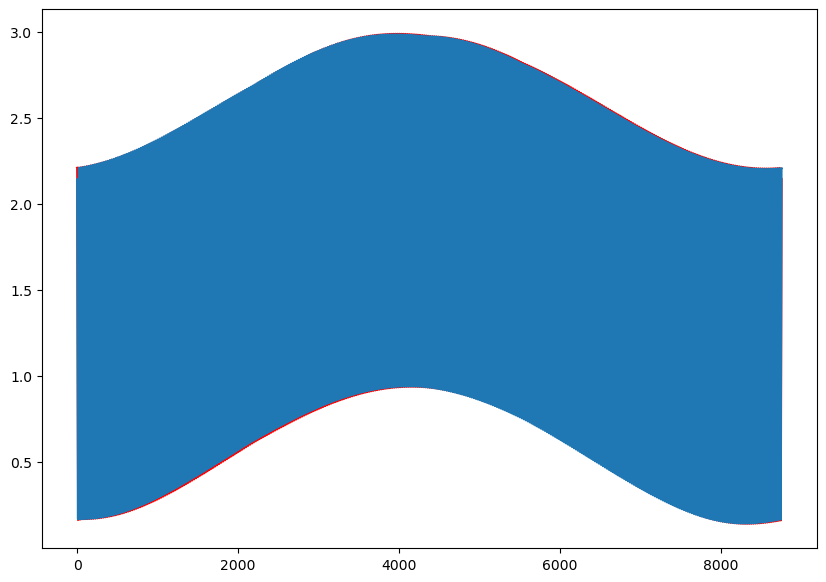

In [144]:
plt.plot(df['Zenith'],color='r')
plt.plot((math.pi/2-selected_data['solar_altitude'].values).tolist())

In [105]:
import pandas as pd
import geopandas as gpd
import numpy as np
import xarray as xr
from shapely.geometry import Point
import math

def extract_solar(cutout, cell):
    """
    
    """
    # pv_inputs ={
	# 	"system_capacity" : 1*1.2, #System size (DC nameplate) [kW]
	# 	"module_type" : 1, # Module type [0/1/2]. Standard,Premium,Thin film
	# 	"dc_ac_ratio" : 1.2,
	# 	"bifaciality" : 0, # Module bifaciality factor [0 or ~0.65]
	# 	"array_type" : 2, # Array type [0/1/2/3/4] fixed open rack,fixed roof mount,1-axis tracking,1-axis backtracking,2-axis tracking
	# 	"azimuth" : 0, # Azimuth angle [deg]
	# 	"gcr" : 0.3, # Ground coverage ratio [0-1]
	# 	"soiling" : [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
	# 	"losses" : 11.42, # Other DC losses [%]
	# 	"en_snowloss" : 0, # Enable snow loss model [0/1]
	# 	"inv_eff" : 96, # Inverter efficiency at rated power [%]
	# 	"batt_simple_enable" : 0,# Enable Battery [0/1]
    #     'tilt': 0, #Tilt angle [deg]
	# }
    pv_inputs={
        #"use_wf_albedo" : 1,
        "system_capacity" : 120000,
        "module_type" : 1,
        "dc_ac_ratio" : 1.1,
        "bifaciality" : 0,
        "array_type" : 2,
        "tilt" : 0,
        "azimuth" : 0,
        "gcr" : 0.3,
        "soiling" : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        "losses" : 11.42, 
        "en_snowloss" : 0,
        "inv_eff" : 96,
        "batt_simple_enable" : 0,
    }
    dates = pd.date_range('2017-01-01 00:00', '2017-12-31 23:00', freq='H')
    year = list(dates.year)
    month = list(dates.month)
    day = list(dates.day)
    hour = list(dates.hour)
    minute = list(dates.minute)

    lat = cutout.grid.loc[cell,'y']
    long = cutout.grid.loc[cell,'x']
    selected_data = cutout.data.sel(x=long, y=lat, method='nearest')

    ghi = (selected_data['influx_direct'] + selected_data['influx_diffuse']).values.tolist()
    direct_horizontal = selected_data['influx_direct'].values.tolist()
    atlite_solar_zenith = (math.pi/2-selected_data['solar_altitude'].values).tolist() 
    direct_normal_atlite = []
    diffuse_horizontal_atlite = []

    for dh, az, g in zip(direct_horizontal, atlite_solar_zenith, ghi):
        if (math.cos(az) > 0.1) and (dh > 10):
            direct_normal = dh / math.cos(az)
            diffuse_horizontal = g - dh
        else:
            direct_normal = 0
            diffuse_horizontal = g - direct_normal
        direct_normal_atlite.append(direct_normal)
        diffuse_horizontal_atlite.append(diffuse_horizontal)

    dni = direct_normal_atlite
    dhi = diffuse_horizontal_atlite

    tdry = (selected_data['temperature'].values-273.15).tolist() # Weather file ambient temperature [C]
    #elev = (selected_data['height'].values).tolist()
    albedo = selected_data['albedo'].values.tolist()
    wspd = selected_data['wnd100m'].values.tolist() # Wind speed at 10 m


    model = pv.new()
    for k, v in pv_inputs.items():
        if k != 'number_inputs':
            setattr(model.SystemDesign, k, v)
    model.AdjustmentFactors.constant = 0
    #data = pd.read_csv('-29.393781_23.307708_-29.3958_23.3099_msg-iodc_60_2017.csv',skiprows=2)

    model.SolarResource.assign(
        {
            'solar_resource_data':{
                'df':dhi, #data['DHI'].tolist(),
                'gh':ghi, #data['GHI'].tolist(),                
                'dn':dni, #data['DNI'].tolist(),
                'tdry':tdry, #data['Temperature'].tolist(),
                'wspd':wspd, #data['Wind Speed'].tolist(),
                'lat':lat,
                'lon':long,
                'tz':2,
                'elev':1045,
                'year':year, #data['Year'].tolist(),
                'month':month, #data['Month'].tolist(),
                'day':day, #data['Day'].tolist(),
                'hour':hour, #data['Hour'].tolist(),
                'minute':minute, #data['Minute'].tolist(),
                'albedo':albedo, #data['Surface Albedo'].tolist(),
                "use_wf_albedo":0,
                }
        }
    )
    
    #model.SolarResource.solar_resource_file = '-29.393781_23.307708_-29.3958_23.3099_msg-iodc_60_2017.csv'

    model.execute()
    ac_output = model.Outputs.ac
    print(atlite_solar_zenith)
 
    return np.array(ac_output)

def process_geometry(cutout, geometry, geometry_name):
    """
    
    """
    # Generate time range for the year
    times = pd.date_range(start='2017-01-01', end='2017-12-31 23:00', freq='H')
    gdf = gpd.GeoDataFrame(cutout.grid, 
                           geometry=[Point(xy) for xy in zip(cutout.grid.x, cutout.grid.y)])

    # Find points within the geometry
    within_geometry = gdf[gdf.geometry.within(geometry)]
    latitudes = np.array(sorted(set(within_geometry['y'])))
    longitudes = np.array(sorted(set(within_geometry['x']))) 

    #Save results in an xarray
    ac_annual_output = xr.DataArray(
        0, 
        coords=[times, latitudes, longitudes],
        dims=["time", "latitude", "longitude"]
    )

    for lat in latitudes:
        for long in longitudes:
            matching_cells = within_geometry.index[(within_geometry.x == long) & (within_geometry.y == lat)]
            if len(matching_cells) > 0:
                cell = matching_cells[0]
                ac_output = extract_solar(cutout, cell)  # Direct call
                ac_annual_output.loc[:, lat, long] = ac_output
    return geometry_name, ac_annual_output


def process_shapefile(cutout, shapefile_path,shapefile_key):
    """
    Process a single shapefile to generate hourly unitised solar profiles for each 
    geometry defined in the shapefile.

    This function reads a shapefile, applies land use exclusions using atlite, and then 
    iterates over each geometry within the shapefile. For each geometry, it extracts solar 
    data based on the geographic area defined by that geometry and compiles the results.

    
    """
    # Read the shapefile and convert its coordinate reference system to EPSG:4326 for latitude
    # and longitude calculations.
    shape_data = gpd.read_file(shapefile_path).to_crs('EPSG:4326')

    results = {}

    has_name = 'Name' in shape_data.columns
    has_corridor = 'Corridor' in shape_data.columns

    # Iterate over each geometry in the shapefile.
    for i, row in shape_data.iterrows():
        if has_name and pd.notnull(row['Name']) and row['Name'] != '':
            geometry_name = f"{shapefile_key}_{row['Name']}"
        elif has_corridor and pd.notnull(row['Corridor']) and row['Corridor'] != '':
            geometry_name = f"{shapefile_key}_{row['Corridor']}"
        else:
            geometry_name = f"{shapefile_key}_{i}"

        # Process the geometry to extract solar data and add the results to the dictionary.
        geometry_name, ac_annual_output  = process_geometry(cutout, 
                                                            row.geometry,
                                                            geometry_name)
        results[geometry_name] = ac_annual_output
    return results

def process_all_shapefiles(cutout, shapefile_dict):
    """
    Process multiple shape files to generate hourly unitised solar profiles for all 
    regions within the shape files.

    Parameters:
    - cutout: atlite cutout containing the ERA 5 meteorological data for the RSA region.
    - shapefile_dict: dictionary containing the shapefile keys and path to the shapefile. 

    Returns:
    - all_results: dictionary containing the shapefile key and the hourly unitised solar profiles

    """
    all_results = {}
    for shapefile_key, shapefile_path in shapefile_dict.items():
        shapefile_results = process_shapefile(cutout, shapefile_path, shapefile_key)
        all_results[shapefile_key] = shapefile_results
     
    return all_results

In [48]:
shapefile_dict = {
    #'redz_1': '../data/bundle/Phase1_REDZs/REDZs.shp',
    #'redz_2': '../data/bundle/Phase2_REDZs/PHASE 2_REDZs.shp',
    #'power_corridor': '../data/bundle/Power_corridors/Power_corridors.shp',
    #'11_supply': '../data/bundle/supply_regions/11-supply.shp',
    '30_supply': '../data/bundle/supply_regions/30-supply.shp'
}

all_geometry_results = process_all_shapefiles(cutout, shapefile_dict)

for shapefile_key, geometries in all_geometry_results.items():
    for geometry_name, data_array in geometries.items():
        filename = f"{geometry_name}.nc"
        if isinstance(data_array, xr.DataArray):
            data_array.to_netcdf(filename)
        else:
            print(f"Unexpected format for {geometry_name}: {type(data_array)}")


In [ ]:
nc_files = [
'redz_1_Stormberg Wind',
'redz_1_Komsberg Wind',
'redz_1_Cookhouse Wind',
'redz_1_Springbok Wind',
'redz_1_Kimberley Solar',
'redz_1_Overberg Wind',
'redz_1_Vryburg Solar',
'redz_1_Upington Solar',
'redz_2_Beaufort West',
'redz_2_Emalahleni',
'redz_2_Klerksdorp',]

capacity_factors = {}
rated_power_capacity = 1000 # DC nameplate capacity 1kW converted to W
for file in nc_files:
    with xr.open_dataset(file + '.nc') as data:
        capacity_factor = data.sum(dim='time')/(rated_power_capacity*8760)
        geometry_name = file.split('_')[2]
        capacity_factors[geometry_name] = capacity_factor

# Compare PySAM Implementation for NRSDB and ERA 5. Point = -29.393781, 23.307708 GreefSpan 1

In [106]:
lat, lon = -29.393781, 23.307708 # Greefspan

target_point = Point(lon, lat)

# find the closest point to target_point in cutout.grid
distances = np.sqrt((cutout.grid.x - target_point.x)**2 + (cutout.grid.y - target_point.y)**2)
closest_point = distances.argmin()

data = pd.read_csv('-29.393781_23.307708_-29.3958_23.3099_msg-iodc_60_2017.csv',skiprows=2)
ac_output_closest_point = extract_solar(cutout, closest_point)
rated_power_capacity = 120000 # DC nameplate capacity 1kW converted to W
capacity_factor = ac_output_closest_point/((rated_power_capacity/1.1)*1000)
capacity_factor.mean()


[2.1927564260593364, 2.0972263753832046, 1.95517581668175, 1.7812585591425114, 1.5863411071722493, 1.3776480536747318, 1.159894092645654, 0.9362848968120132, 0.7092947867921773, 0.48163870462483604, 0.26015784946052833, 0.11232677232764576, 0.2599007722799127, 0.48138358464808806, 0.7090744762508803, 0.936121058472087, 1.1598100586535507, 1.3776719991072728, 1.5865084876921696, 1.7816141859869323, 1.9557734936792746, 2.0981198167226696, 2.1939712931589486, 2.2284279940762555, 2.1947191558060695, 2.0994753659748002, 1.9575560863090267, 1.7836756467123722, 1.5887468961774824, 1.380021392331517, 1.1622287626904613, 0.938584545847258, 0.711573803600885, 0.48393245760888637, 0.2625514729263474, 0.11390357140112384, 0.2590190175026932, 0.48015929441309413, 0.7078166447672445, 0.9349216469175693, 1.158722286412456, 1.3767439498195007, 1.585795929338244, 1.7811890861924304, 1.9557296372466828, 2.098567823944806, 2.195004036510693, 2.2300490318301343, 2.1968009805846385, 2.10182691964963, 1.960

0.26826859580961987

In [131]:
import PySAM.Pvwattsv5 as pvwatts
import pandas as pd
# Latitude and longitude
latitude = cutout.grid.loc[closest_point,'y']  # Example latitude
longitude = cutout.grid.loc[closest_point,'x']  # Example longitude
# Initialize PVWatts model  
model_ = pvwatts.default('None')
# Set location parameters
model_.SolarResource.solar_resource_file = None
model_.SystemDesign.lat = latitude
model_.SystemDesign.lon = longitude
# Create a DataFrame to store results
results = pd.DataFrame()
# Iterate through each hour of the year
for day in range(365):
    for hour in range(24):
        model_.SystemDesign.hour = hour
        model_.SystemDesign.day = day
        # Execute model
        model_.execute()
        # Collect solar angle data
        solar_angles = {
            'day': day,
            'hour': hour,
            'solar_azimuth': model_.Outputs.solar_azimuth,
            'solar_zenith': model_.Outputs.solar_zenith
        }
        # Append results
        results = results.append(solar_angles, ignore_index=True)
# Display results
print(results)

Exception: Default configuration by that name was not found.

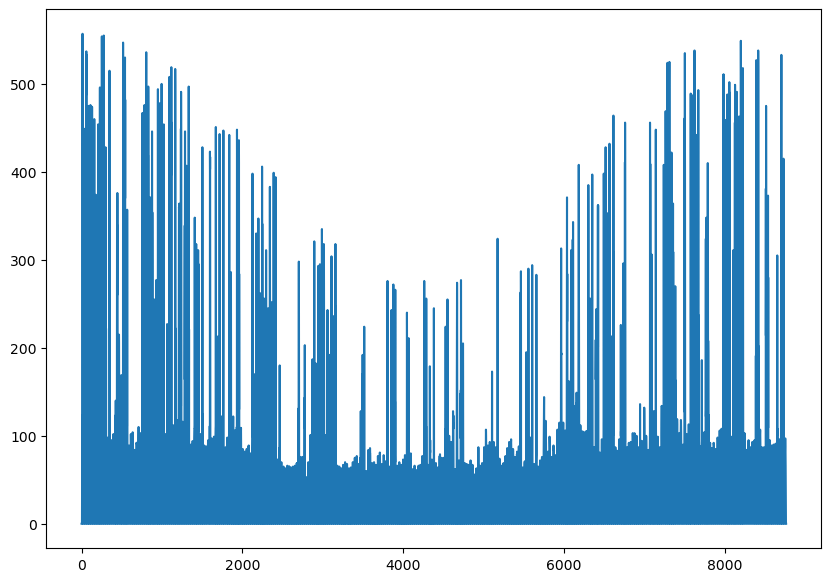

In [96]:
plt.plot(data['DHI'])

In [85]:
pysam_result = pd.read_csv('pysam_profiles_1H.csv')['Greefspan1']
pysam_result.loc[range(0,8761)].mean()

0.286837520635925

# Comparison of PySAM with ATLITE for REDZ1 and REDZ2

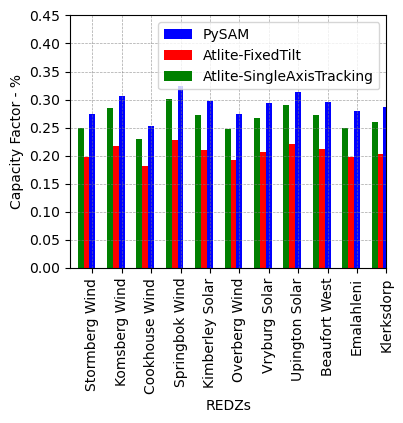

In [33]:
# shapefile_dict = {
#     'redz_1': '../data/bundle/Phase1_REDZs/REDZs.shp',
#     'redz_2': '../data/bundle/Phase2_REDZs/PHASE 2_REDZs.shp',
#     #'power_corridor': '../data/bundle/Power_corridors/Power_corridors.shp',
#     #'11_supply': '../data/bundle/supply_regions/11-supply.shp',
#     #'30_supply': '../data/bundle/supply_regions/30-supply.shp'
# }

# all_geometry_results = process_all_shapefiles(cutout, shapefile_dict)

# for geometry_name, data_array in all_geometry_results.items():
#     filename = f"{geometry_name}.nc"
#     data_array.to_netcdf(filename)

nc_files = [
'redz_1_Stormberg Wind',
'redz_1_Komsberg Wind',
'redz_1_Cookhouse Wind',
'redz_1_Springbok Wind',
'redz_1_Kimberley Solar',
'redz_1_Overberg Wind',
'redz_1_Vryburg Solar',
'redz_1_Upington Solar',
'redz_2_Beaufort West',
'redz_2_Emalahleni',
'redz_2_Klerksdorp']

capacity_factors = {}
rated_power_capacity = 1000 # AC nameplate capacity 1kW converted to W
for file in nc_files:
    with xr.open_dataset(file + '.nc') as data:
        capacity_factor = data.sum(dim='time')/(rated_power_capacity*8760)
        geometry_name = file.split('_')[2]
        capacity_factors[geometry_name] = capacity_factor

capacities_redz = pd.DataFrame(index=capacity_factors.keys(), columns=['cap_factor'])
for key in capacity_factors.keys():
    #print(f"Processing key: {key}")
    df = capacity_factors[key]
    df = df.to_dataframe().reset_index()
    df_filtered = df[df["__xarray_dataarray_variable__"] != 0]
    mean_value = df_filtered["__xarray_dataarray_variable__"].mean()
    capacities_redz.loc[key, 'cap_factor'] = mean_value

mean_values_sat = {}
mean_values_ft = {}

for name in pv_sat.Name.values:
    mean_values_sat[name] = pv_sat.sel(Name=name).values.mean()
    mean_values_ft[name] = pv_ft.sel(Name=name).values.mean()   

mean_values_df_sat = pd.DataFrame(list(mean_values_sat.items()), columns=['redz', 'cap_factor'])
mean_values_df_sat.set_index('redz', inplace=True)

mean_values_df_ft = pd.DataFrame(list(mean_values_ft.items()), columns=['redz', 'cap_factor'])
mean_values_df_ft.set_index('redz', inplace=True)

# Plotting
cm = 1/2.54
defaultFigureWidth = 10.5 * cm
defaultFigureHeight = 11 * cm
fig, ax = plt.subplots(figsize=(defaultFigureWidth, defaultFigureHeight))
bar_width = 0.2
n_groups = len(mean_values_df_ft.index)
index = np.arange(n_groups)
index_shifted = index + bar_width

capacities_redz.plot(kind='bar', ax=ax, width=bar_width, position=0, color='b')
mean_values_df_ft.plot(kind='bar', ax=ax, width=bar_width, position=1, color='r')
mean_values_df_sat.plot(kind='bar', ax=ax, width=bar_width, position=2, color='g')


ax.legend(title='',labels=['PySAM','Atlite-FixedTilt','Atlite-SingleAxisTracking'])
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(mean_values_df_ft.index)
plt.ylim(0,0.45)
ax.set_xlabel('REDZs')
ax.set_ylabel('Capacity Factor - %')
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
plt.tight_layout()

plt.show()


# Comparison of PySAM with CSIR 27-supply data

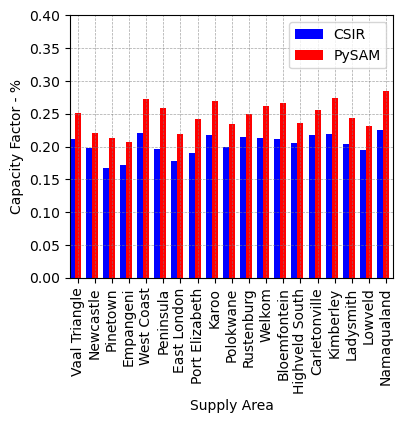

In [49]:
nc_files = [
'30_supply_Bloemfontein',
'30_supply_Carletonville',
'30_supply_East London',
'30_supply_East Rand',
'30_supply_Empangeni',
'30_supply_Highveld South',
'30_supply_Johannesburg North',
'30_supply_Johannesburg South',
'30_supply_Karoo',
'30_supply_Kimberley',
'30_supply_Ladysmith',
'30_supply_Lephalale',
'30_supply_Lowveld',
'30_supply_Middelburg',
'30_supply_Namaqualand',
'30_supply_Newcastle',
'30_supply_Outeniqua',
'30_supply_Peninsula',
'30_supply_Phalaborwa',
'30_supply_Pinetown',
'30_supply_Polokwane',
'30_supply_Port Elizabeth',
'30_supply_Rustenburg',
'30_supply_Sasolburg',
'30_supply_Tshwane',
'30_supply_Vaal Triangle',
'30_supply_Welkom',
'30_supply_West Coast',
'30_supply_West Rand',
'30_supply_Witbank',
]

csir_data = pd.read_excel('../data/bundle/Supply area normalised power feed-in for PV.xlsx', 
                          sheet_name='PV profiles', 
                          index_col=0,
                          skiprows=[1])

capacity_factors = {}
rated_power_capacity = 1000 # DC nameplate capacity 1kW converted to W
for file in nc_files:
    with xr.open_dataset(file + '.nc') as data:
        capacity_factor = data.sum(dim='time')/(rated_power_capacity*8760)
        geometry_name = file.split('_')[2]
        capacity_factors[geometry_name] = capacity_factor

capacities_30_supply = pd.DataFrame(index=capacity_factors.keys(), columns=['cap_factor'])
for key in capacity_factors.keys():
    #print(f"Processing key: {key}")
    df = capacity_factors[key]
    df = df.to_dataframe().reset_index()
    df_filtered = df[df["__xarray_dataarray_variable__"] != 0]
    mean_value = df_filtered["__xarray_dataarray_variable__"].mean()
    capacities_30_supply.loc[key, 'cap_factor'] = mean_value
    
cm = 1/2.54
defaultFigureWidth = 10.5 * cm
defaultFigureHeight = 11 * cm

csir_data = csir_data.resample('H').mean()
csir_data.columns = [x.title() for x in csir_data.columns]          

# Only plot common supply areas
common_areas = csir_data.columns.intersection(capacities_30_supply.index)

csir_data_common = csir_data[common_areas].mean()
capacities_30_supply_common = capacities_30_supply.loc[common_areas, 'cap_factor']
n_groups = len(common_areas)

fig, ax = plt.subplots(figsize=(defaultFigureWidth, defaultFigureHeight))
bar_width = 0.35
index = np.arange(n_groups)
index_shifted = index + bar_width

csir_data_common.plot(kind='bar', ax=ax, width=bar_width, position=1, color='b')
capacities_30_supply_common.plot(kind='bar', ax=ax, width=bar_width, position=0, color='r')

ax.legend(title='',labels=['CSIR','PySAM'])
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(common_areas)
ax.set_xlabel('Supply Area')
ax.set_ylabel('Capacity Factor - %')
plt.ylim(0,0.4)
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
plt.tight_layout()

plt.show()


In [122]:
idx = pd.date_range('2017-01-01', '2017-12-31 23:00', freq='H')
pu = pd.DataFrame(np.nan, index=idx, columns=capacities_30_supply.index)

rated_power_capacity = 1000 # DC nameplate capacity 1kW converted to W

for file in nc_files:
    with xr.open_dataset(file + '.nc') as data:
        geometry_name = file.split('_')[2]
        pu_mean = data.mean(dim=['latitude','longitude'])/rated_power_capacity
        pu_mean = pu_mean.to_dataframe()
        pu[geometry_name] = pu_mean['__xarray_dataarray_variable__']
pu['Johannesburg South'] = pu['Johannesburg North']

/home/joules/miniforge3/envs/pypsa-eur/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [123]:
pu

,Bloemfontein,Carletonville,East London,East Rand,Empangeni,Highveld South,Johannesburg North,Johannesburg South,Karoo,Kimberley,...,Polokwane,Port Elizabeth,Rustenburg,Sasolburg,Tshwane,Vaal Triangle,Welkom,West Coast,West Rand,Witbank
2017-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 19:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-12-31 20:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-12-31 21:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-12-31 22:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# cutout = atlite.Cutout(
#     path="../cutouts/RSA-2013-era5.nc",#"../cutouts/RSA-2017_20-era5.nc",
#     chunks={"time": 100},
# )
# cutout.data = cutout.data.sel(time=slice('2013-01-01', '2013-12-31')) #cutout.data.sel(time=slice('2019-01-01', '2019-12-31'))

# pv_sat = cutout.pv(    
#     panel="CSi",
#     shapes=cutout.grid,
#     tracking="horizontal",
#     per_unit=True, 
#     orientation={"slope": 0.0, "azimuth": 0},
#     **resource,
# )

# pv_ft = cutout.pv(    
#     panel="CSi",
#     shapes=cutout.grid,
#     tracking=None,
#     per_unit=True, 
#     orientation="latitude_optimal", # or {"slope": 0.0, "azimuth": 0},
#     **resource,
# )

In [ ]:
# rsa_supply = gpd.read_file('../data/bundle/rsa_supply_regions.gpkg', layer='1-supply')

In [ ]:
# pv_ft.sel(dim_0=1).plot(color='r')
# pv_sat.sel(dim_0=1).plot()

In [ ]:
# import os
# import PySAM.ResourceTools as tools  # MOVE BACK TO FILES FOLDER
# import PySAM.Windpower as wp
# import PySAM.Singleowner as so
# import PySAM.Pvwattsv8 as pv

# # replace with key and email address from https://developer.nrel.gov/signup/
# sam_api_key = '6VaYhZeU4bC1yNMhQ9fzGHjaVjucP6iSQu5MTrhL'
# sam_email = 'peter.klein@meridianeconomics.co.za'

# sam_api_key_NM = 'EGQeUyrDX6B25t4df7U7PuAFZsYb43m7jbl3hbDQ'
# sam_email_NM = 'ndivhuwo.musehane@meridianeconomics.co.za'

# # lon = -105.22
# # lat = 39.75

In [ ]:
# # --- Initialize Solar Resource Fetcher with minimum parameters ---
# # See function documentation for full parameter list
# for cell in cutout.grid.index[0:5]:
#     lon = cutout.grid.loc[cell,'x']
#     lat = cutout.grid.loc[cell,'y']

#     nsrdbfetcher = tools.FetchResourceFiles(
#                     tech='solar',
#                     nrel_api_key=sam_api_key_NM,
#                     nrel_api_email=sam_email_NM)

#     # --- List of (lon, lat) tuples or Shapely points ---
#     lon_lats = [(lon, lat)]
#     nsrdbfetcher.fetch(lon_lats)

#     # --- Get resource data file path ---
#     nsrdb_path_dict = nsrdbfetcher.resource_file_paths_dict
#     nsrdb_fp = nsrdb_path_dict[lon_lats[0]]

In [ ]:
# from dask import delayed, compute

# # Assuming your function extract_solar and cutout object are already defined

# # Create delayed objects for each function call
# tasks = [delayed(extract_solar)(cutout, cell) for cell in cutout.grid.index[0:10]]

# # Compute the results in parallel
# results = compute(*tasks)

# print(results)


In [ ]:
# results

# Comparison of DNI data: SAURAN, ERA5-pvgis, SARAH2-pvgis, NSRDB, ERA5-ATLITE

### Clean Saruan data

In [ ]:
var = pd.read_excel('../data/resource_validation/sauran_locations.xlsx',index_col=1)

saruan_data = {}

for key in var.index:
    print("Processing:", key)
    dhi_column = var.loc[key,'DHI']
    dni_column = var.loc[key,'DNI']
    ghi_column = var.loc[key,'GHI']

    file_path = f'../data/resource_validation/sauran/{key} Hour.csv'
    file = pd.read_csv(file_path,
                    header=[1,2,3],
                    index_col=0,
                    parse_dates=True,
                    dayfirst=True)
    file.columns = file.columns.droplevel([1,2])

    standardized_columns = {dhi_column: 'DHI', dni_column: 'DNI', ghi_column: 'GHI'}
    subset_data = file[[dhi_column, dni_column, ghi_column]].rename(columns=standardized_columns)

    saruan_data[key] = subset_data

Processing: KZH
Processing: KZW
Processing: SUN
Processing: UPR
Processing: VAN
Processing: UFS
Processing: GRT
Processing: NMU
Processing: RVD
Processing: STA
Processing: SUT
Processing: UBG
Processing: UNV
Processing: UNZ
Processing: NUST
Processing: FRH
Processing: MRB
Processing: HLO
Processing: SALT
Processing: CSIR
Processing: CUT
Processing: PMB
Processing: ILA
Processing: MIN


### Clean SARAH2 data

In [ ]:
sarah2_data = {}    
for key in var.index:
    lat = round(var.loc[key, 'Latitude'], 3)
    long = round(var.loc[key, 'Longitude'], 3)

    lat = "{:.3f}".format(lat)
    long = "{:.3f}".format(long)
    print("Processing:", key)

    file_path = f'../data/resource_validation/pvgis_sarah2/Timeseries_{lat}_{long}_SA2_0deg_0deg_2017_2019.csv'
    df = pd.read_csv(file_path,
                skiprows=[0,1,2,3,4,5,6,7],
                index_col=0,
                skipfooter=12,
                engine='python')
    df.index = pd.to_datetime(df.index, format='%Y%m%d:%H%M')

    sarah2_data[key] = df.resample('H').mean()

Processing: KZH
Processing: KZW
Processing: SUN
Processing: UPR
Processing: VAN
Processing: UFS
Processing: GRT
Processing: NMU
Processing: RVD
Processing: STA
Processing: SUT
Processing: UBG
Processing: UNV
Processing: UNZ
Processing: NUST
Processing: FRH
Processing: MRB
Processing: HLO
Processing: SALT
Processing: CSIR
Processing: CUT
Processing: PMB
Processing: ILA
Processing: MIN


### Clean ERA5 data

In [ ]:
era5_data = {}    
for key in var.index:
    lat = round(var.loc[key, 'Latitude'], 3)
    long = round(var.loc[key, 'Longitude'], 3)

    lat = "{:.3f}".format(lat)
    long = "{:.3f}".format(long)
    print("Processing:", key)

    file_path = f'../data/resource_validation/pvgis_era5/Timeseries_{lat}_{long}_E5_0deg_0deg_2017_2019.csv'
    df = pd.read_csv(file_path,
                skiprows=[0,1,2,3,4,5,6,7],
                index_col=0,
                skipfooter=12,
                engine='python')
    df.index = pd.to_datetime(df.index, format='%Y%m%d:%H%M')

    era5_data[key] = df.resample('H').mean()

Processing: KZH
Processing: KZW
Processing: SUN
Processing: UPR
Processing: VAN
Processing: UFS
Processing: GRT
Processing: NMU
Processing: RVD
Processing: STA
Processing: SUT
Processing: UBG
Processing: UNV
Processing: UNZ
Processing: NUST
Processing: FRH
Processing: MRB
Processing: HLO
Processing: SALT
Processing: CSIR
Processing: CUT
Processing: PMB
Processing: ILA
Processing: MIN


### Download and clean NSRDB data

In [ ]:
%matplotlib inline
import h5pyd
from scipy.spatial import cKDTree


nsrdb_2017 = h5pyd.File("/nrel/nsrdb/meteosat/meteosat_2017.h5", 'r')
nsrdb_2018 = h5pyd.File("/nrel/nsrdb/meteosat/meteosat_2018.h5", 'r')
nsrdb_2019 = h5pyd.File("/nrel/nsrdb/meteosat/meteosat_2019.h5", 'r')

In [ ]:
dset_coords_2017 = nsrdb_2017['coordinates'][...]
tree = cKDTree(dset_coords_2017)

def nearest_site(tree, lat_coord, lon_coord):
    lat_lon = np.array([lat_coord, lon_coord])
    dist, pos = tree.query(lat_lon)
    return pos

def unscale_dset(nsrdb_2017, dset_name, idx):
    dset = nsrdb_2017[dset_name]
    return dset[:, idx] / dset.attrs['psm_scale_factor']

nsrdb_data = {}  
for key in var.index:
    lat = var.loc[key, 'Latitude']
    long = var.loc[key, 'Longitude']
    idx = nearest_site(tree, lat, long)
    %time df = pd.DataFrame({"air_temperature": unscale_dset(nsrdb_2017, 'air_temperature', idx),\
                            "wind_speed": unscale_dset(nsrdb_2017, 'wind_speed', idx),\
                            "ghi": unscale_dset(nsrdb_2017, 'ghi', idx),\
                            "dhi": unscale_dset(nsrdb_2017, 'dhi', idx),\
                            "dni": unscale_dset(nsrdb_2017, 'dni', idx)},\
                            index=nsrdb_2017['time_index'][...].astype(str))
    
    # save df in multi-index dataframe by key
    nsrdb_data[key] = df 

CPU times: user 1.85 s, sys: 369 ms, total: 2.22 s
Wall time: 9.11 s
CPU times: user 1.2 s, sys: 344 ms, total: 1.54 s
Wall time: 6.61 s
CPU times: user 1.32 s, sys: 179 ms, total: 1.5 s
Wall time: 7.42 s
CPU times: user 1.5 s, sys: 171 ms, total: 1.67 s
Wall time: 7.08 s
CPU times: user 1.25 s, sys: 233 ms, total: 1.48 s
Wall time: 6.9 s
CPU times: user 1.33 s, sys: 171 ms, total: 1.5 s
Wall time: 7.3 s
CPU times: user 2.07 s, sys: 376 ms, total: 2.45 s
Wall time: 7.64 s
CPU times: user 2.22 s, sys: 518 ms, total: 2.74 s
Wall time: 7.8 s
CPU times: user 1.74 s, sys: 266 ms, total: 2.01 s
Wall time: 7.15 s
CPU times: user 2.23 s, sys: 423 ms, total: 2.65 s
Wall time: 7.52 s
CPU times: user 2.08 s, sys: 305 ms, total: 2.38 s
Wall time: 7.25 s
CPU times: user 1.7 s, sys: 338 ms, total: 2.04 s
Wall time: 7.56 s
CPU times: user 1.84 s, sys: 344 ms, total: 2.19 s
Wall time: 7.7 s
CPU times: user 2.05 s, sys: 452 ms, total: 2.51 s
Wall time: 8.11 s
CPU times: user 1.37 s, sys: 202 ms, total:

Text(0.5, 1.0, 'University of KwaZulu-Natal Howard College')

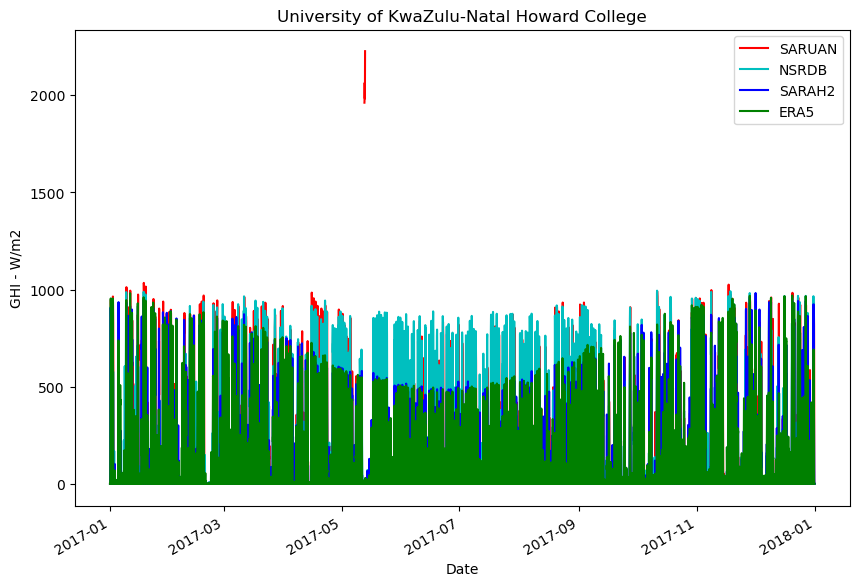

In [ ]:
# Plot saruan_data, sarah2_data and era5_data in one plot
plt.rc("figure", figsize=[10, 7])
fig, ax = plt.subplots()
saruan_data['KZH'][['DNI']].loc['2017'].plot(ax=ax, color='r', label='SARUAN')

nsrdb_1 = nsrdb_data['KZH'][['dni']]
nsrdb_1.index = pd.to_datetime(nsrdb_1.index, format="%Y-%m-%d %H:%M:%S")
nsrdb_1.loc['2017'].resample('H').mean().plot(ax=ax, color='c', label='NSRDB')

sarah2_data['KZH'][['Gb(i)']].loc['2017'].plot(ax=ax, color='b', label='SARAH2')
era5_data['KZH'][['Gb(i)']].loc['2017'].plot(ax=ax, color='g', label='ERA5')
#plt.plot(dn_calc)
ax.legend(title='',labels=['SARUAN','NSRDB','SARAH2','ERA5','Atlite'])
ax.set_xlabel('Date')
ax.set_ylabel('GHI - W/m2')
ax.set_title(var.loc['KZH']['Name'])


[False False False ... False False False]


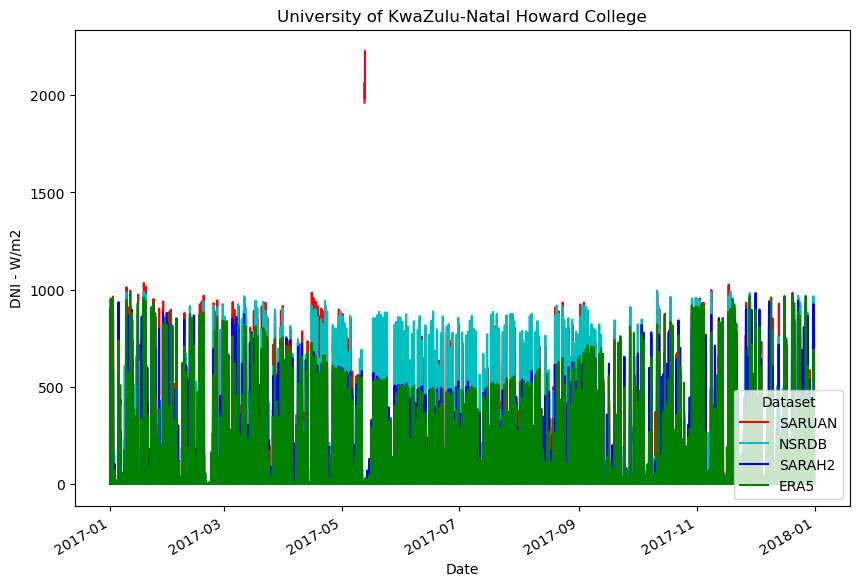

[False False False ... False False False]


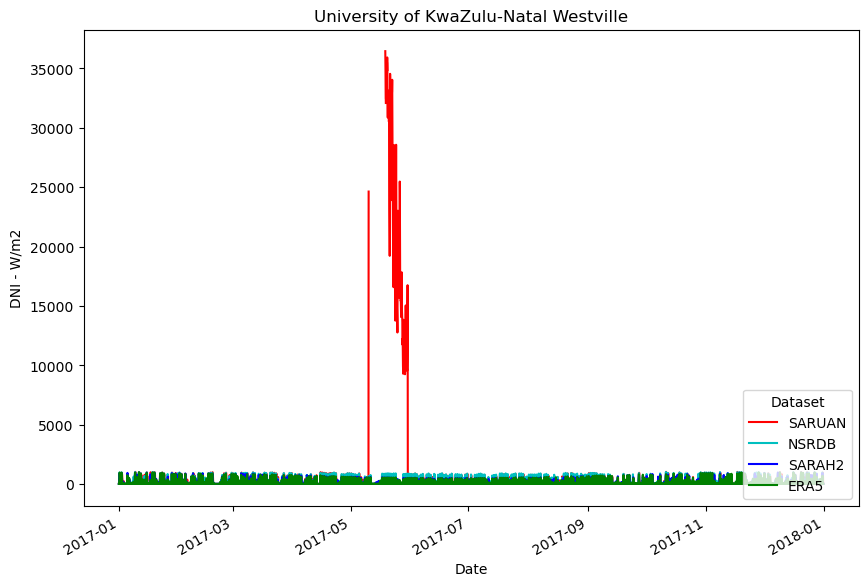

[ True  True  True ... False False False]


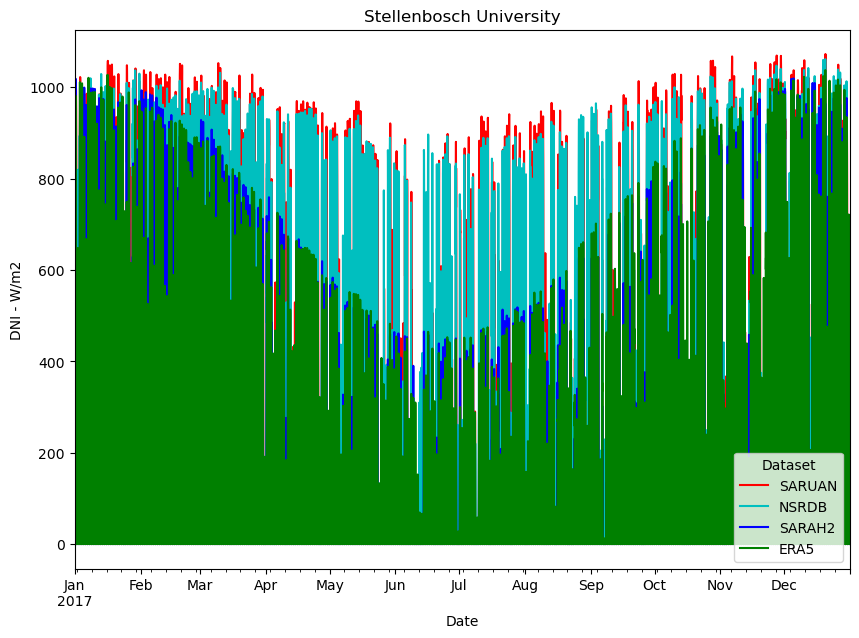

[False False False ... False False False]


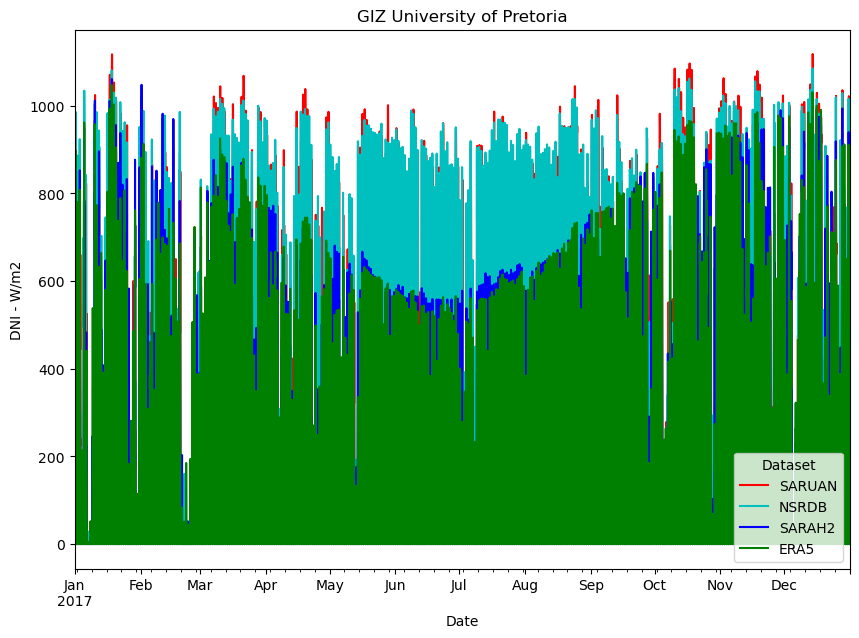

[ True  True  True ... False False False]


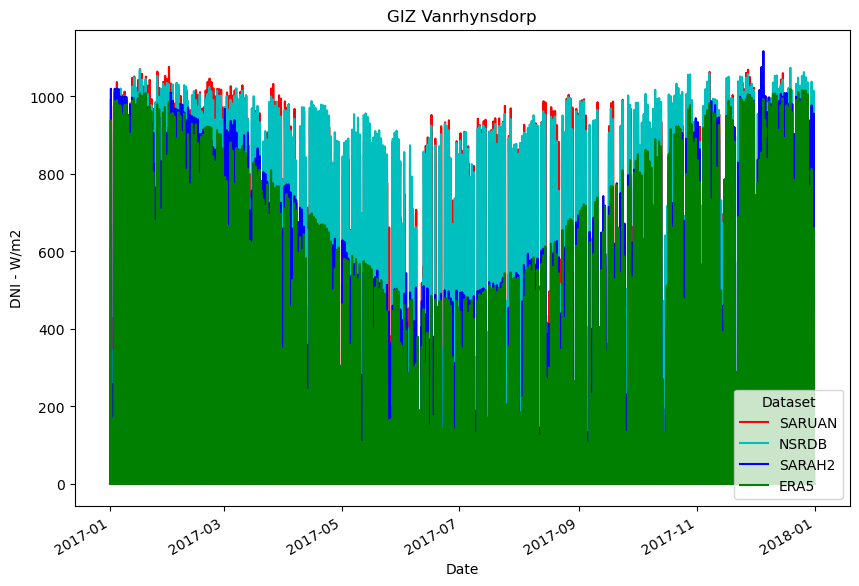

[False False False ...  True  True  True]


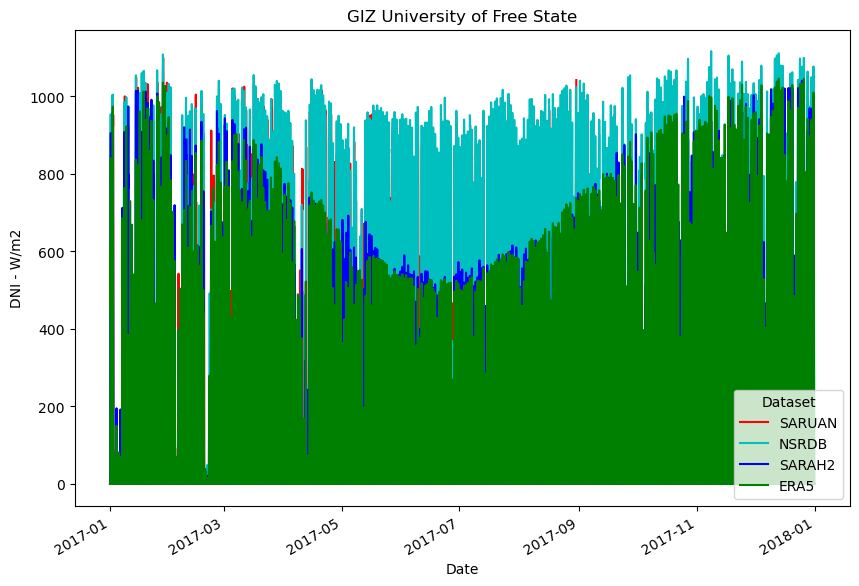

[False False False ... False False False]


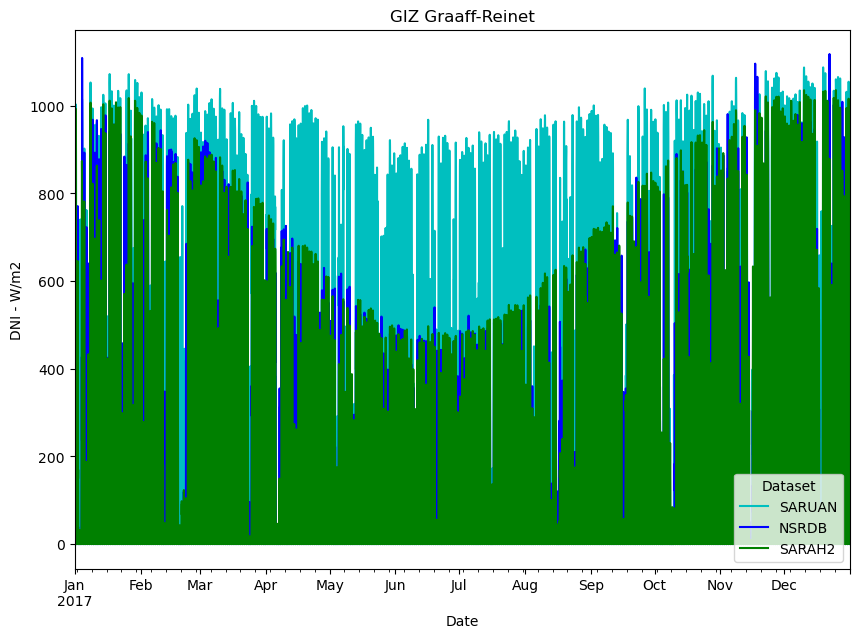

[ True  True  True ... False False False]


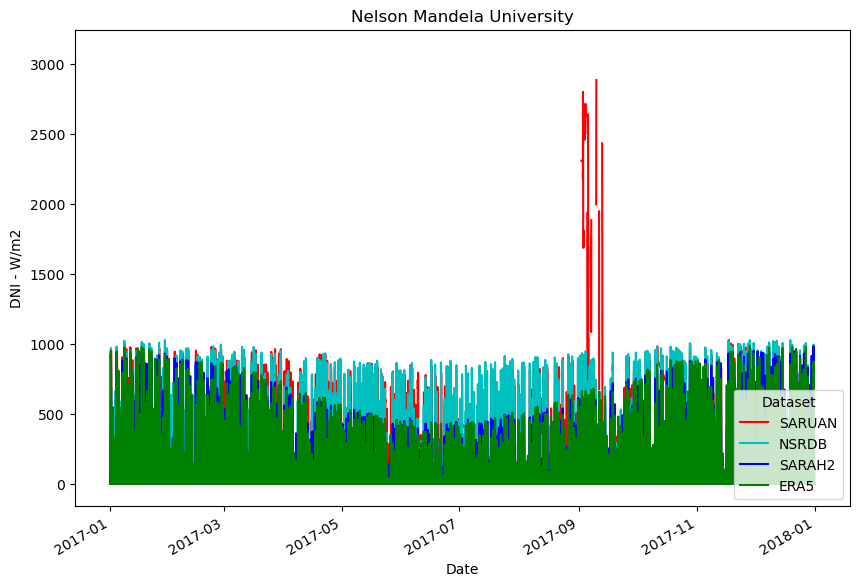

[ True  True  True ... False False False]


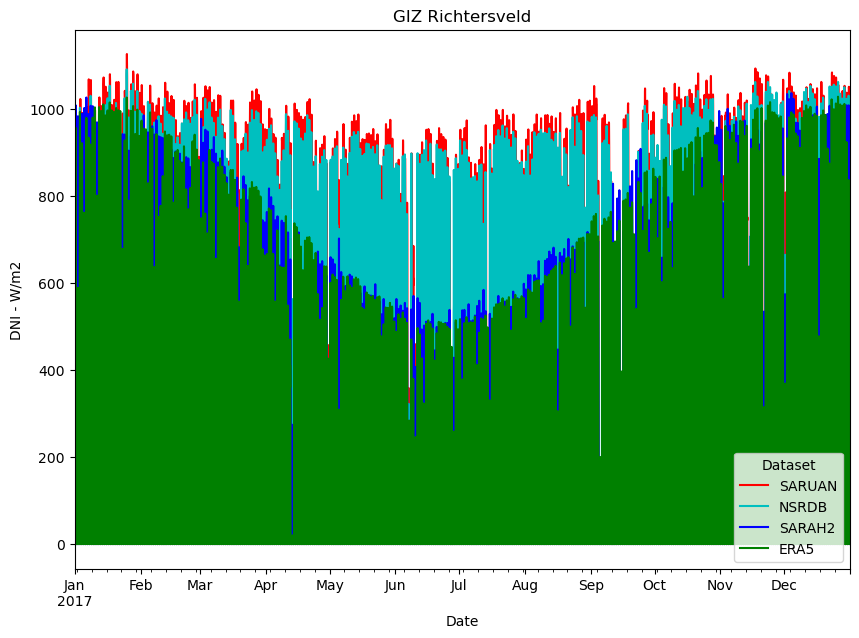

[False False False ... False False False]


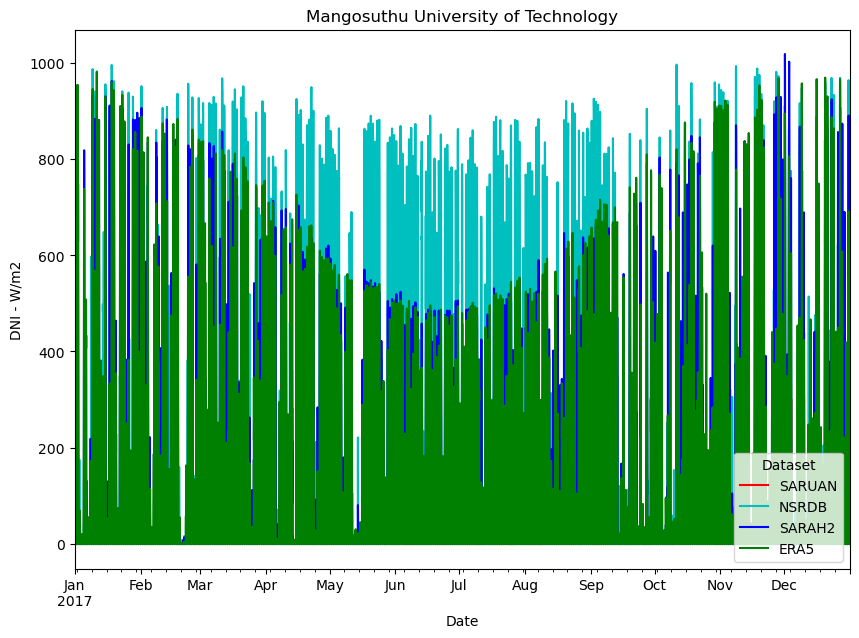

[ True  True  True ...  True  True  True]


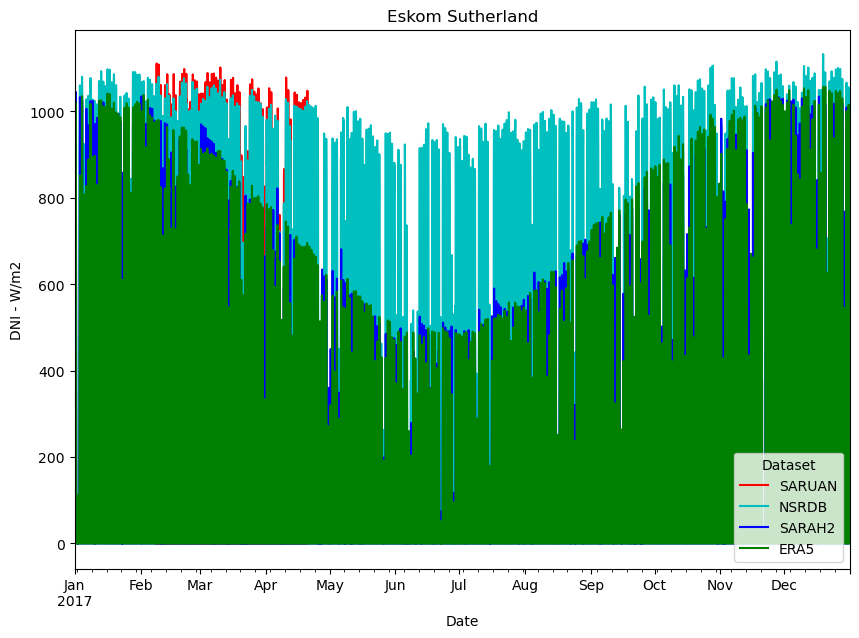

[False False False ... False False False]


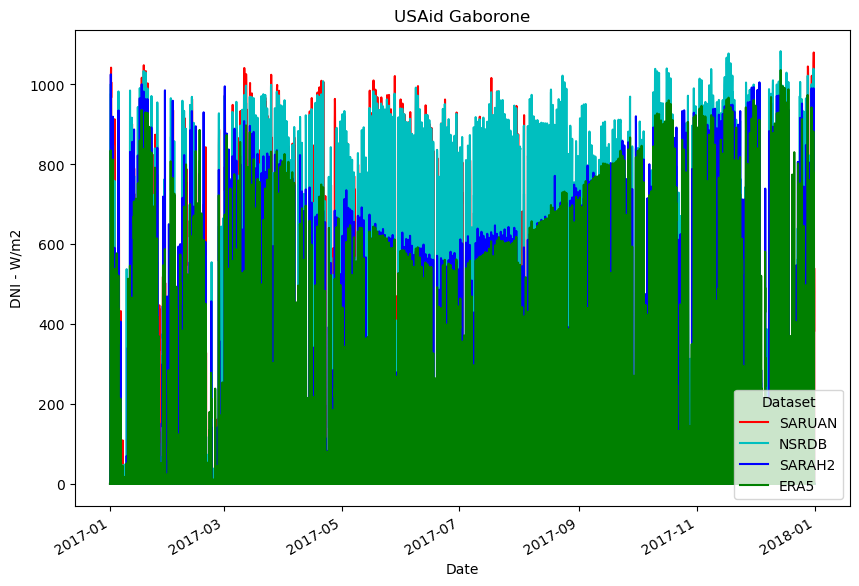

[False False False ... False False False]


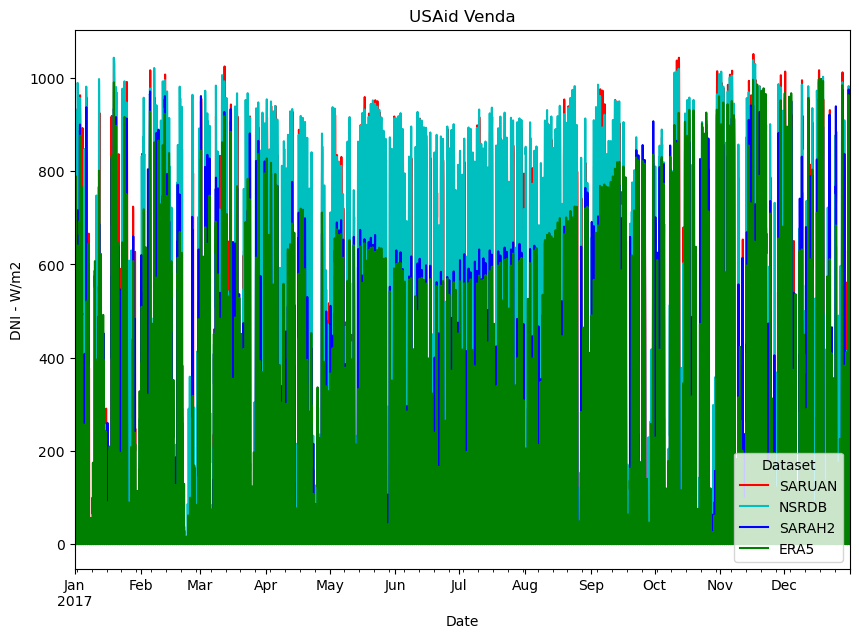

[False False False ... False False False]


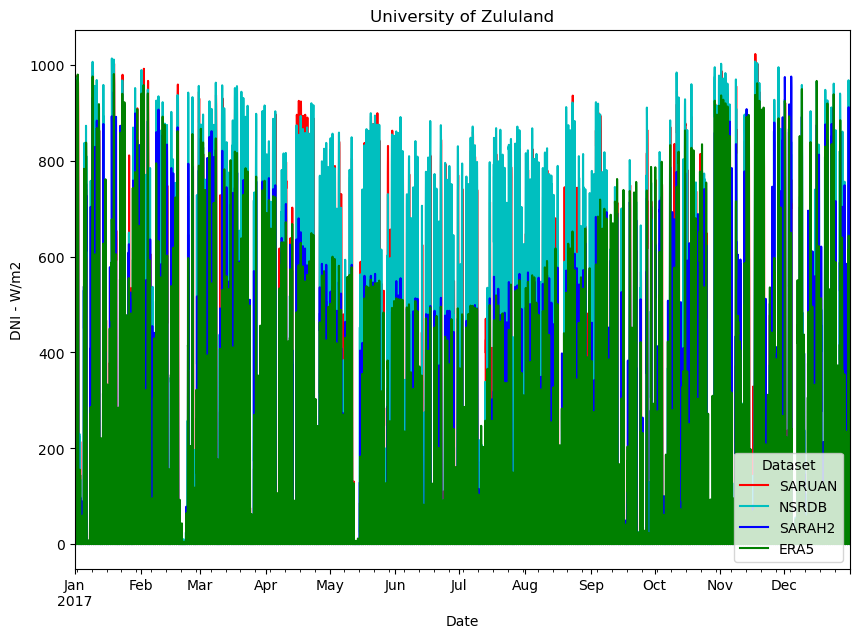

[ True  True  True ... False False False]


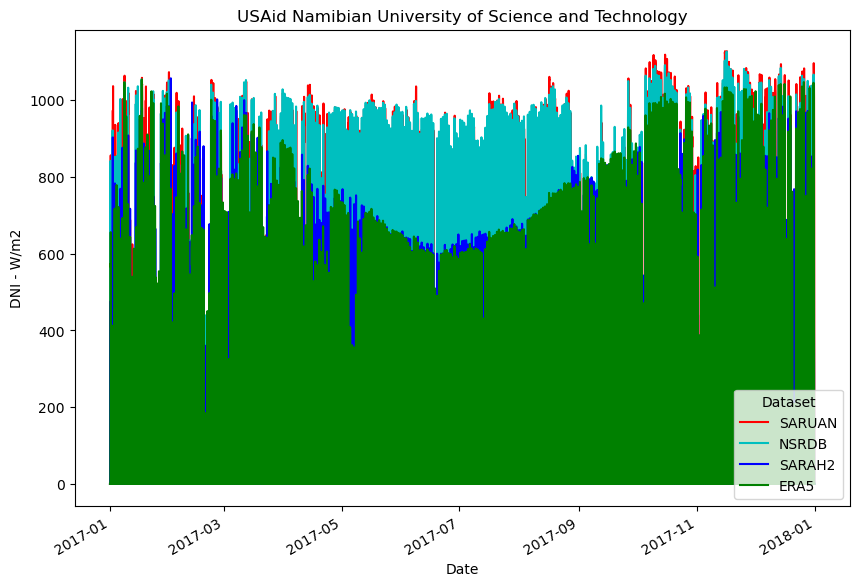

[ True  True  True ... False False False]


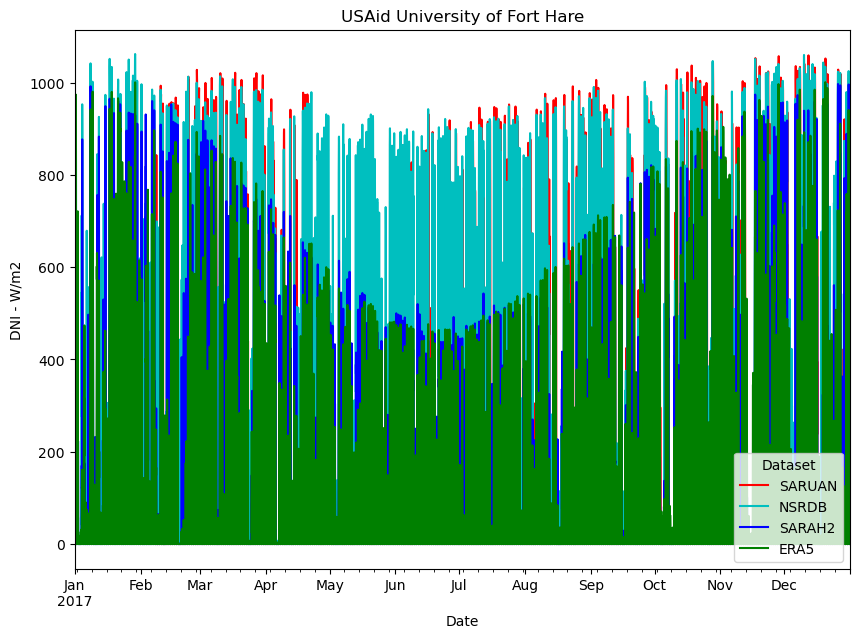

[ True  True  True ... False False False]


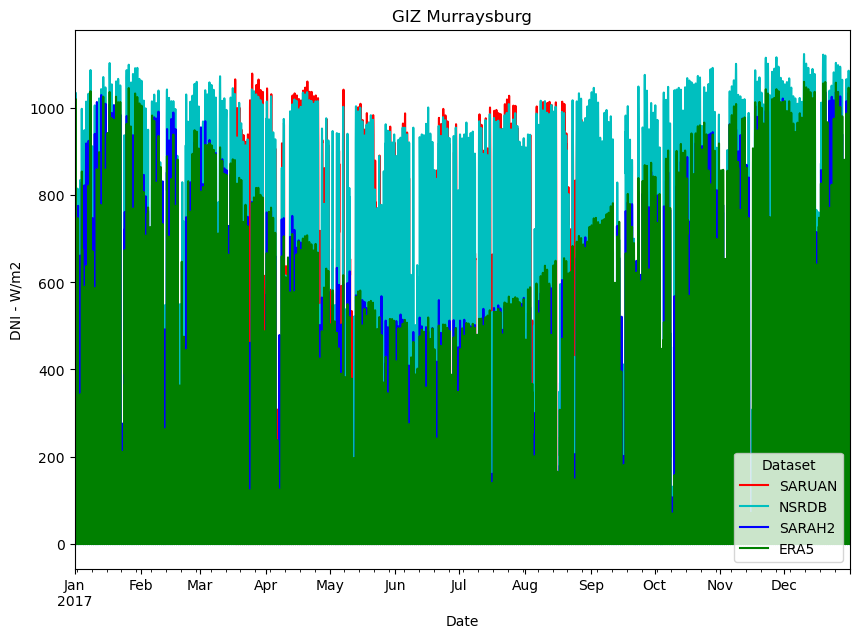

[ True  True  True ... False False False]


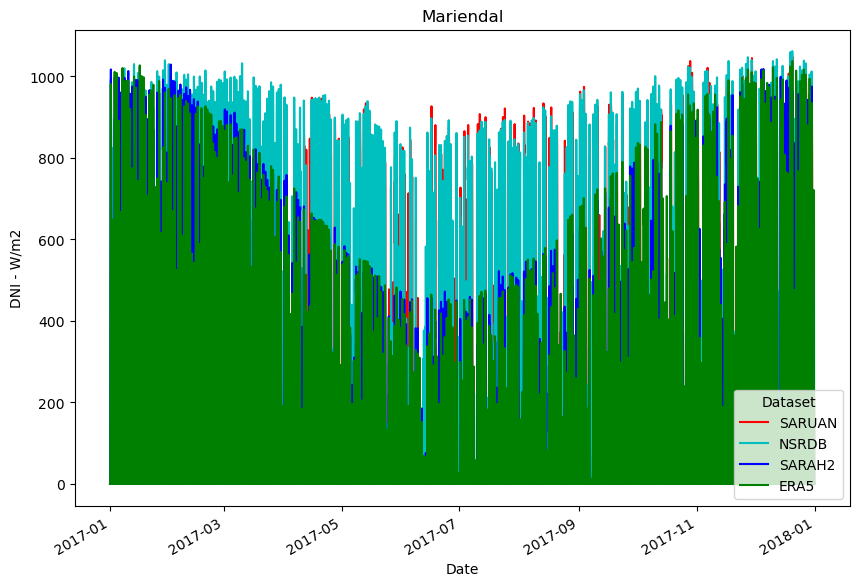

[ True  True  True ... False False False]


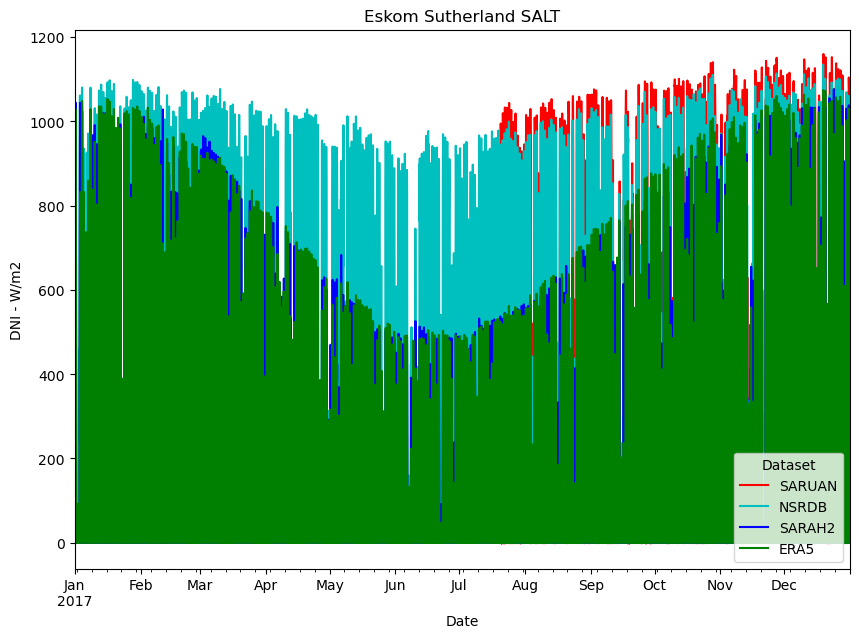

[ True  True  True ... False False False]


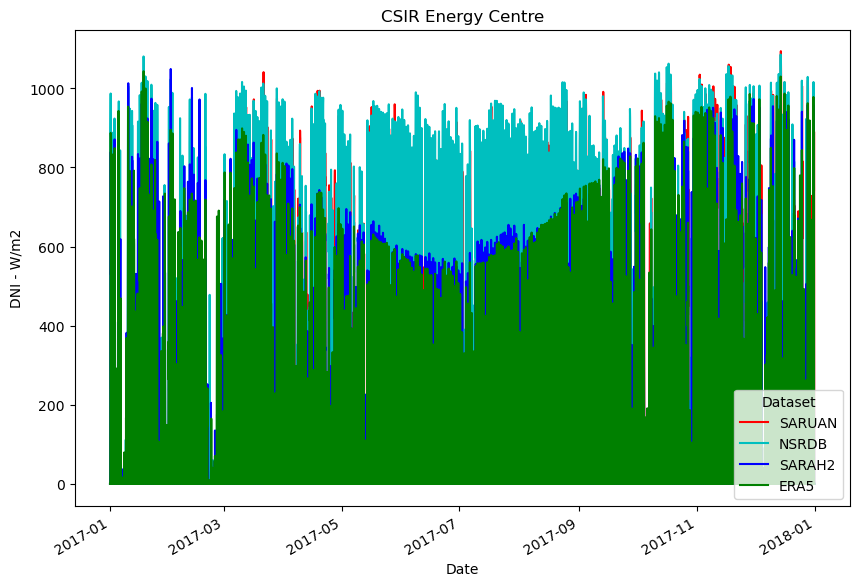

[ True  True  True ... False False False]


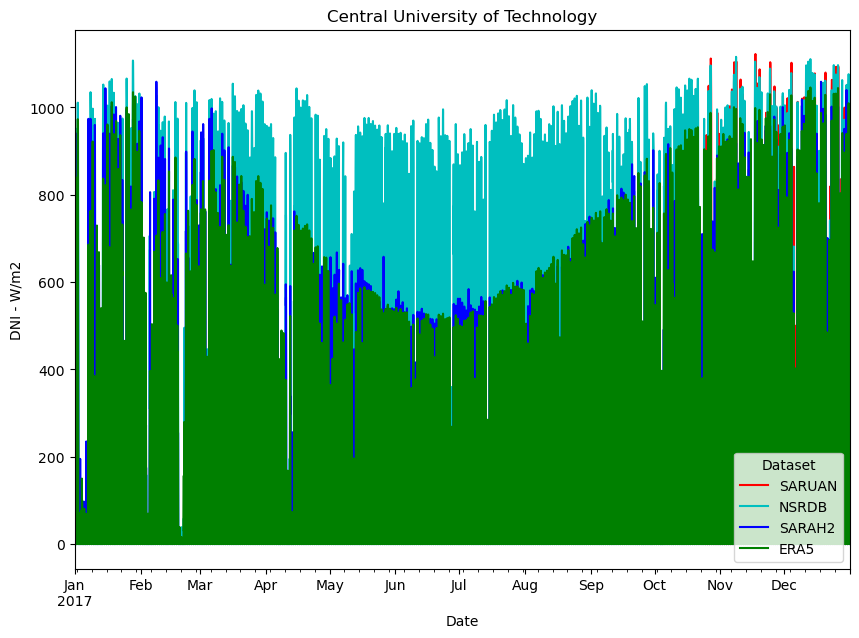

[False False False ... False False False]


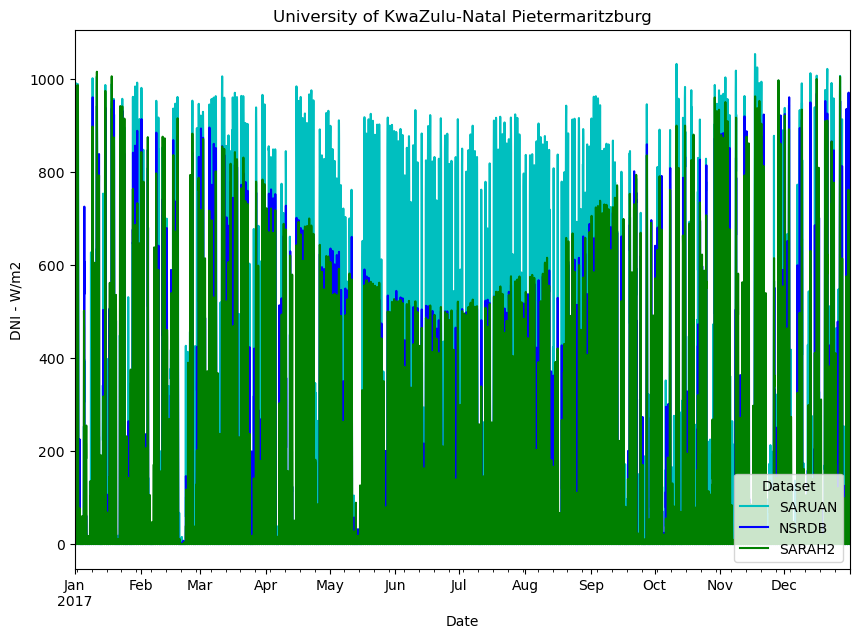

[False False False ... False False False]


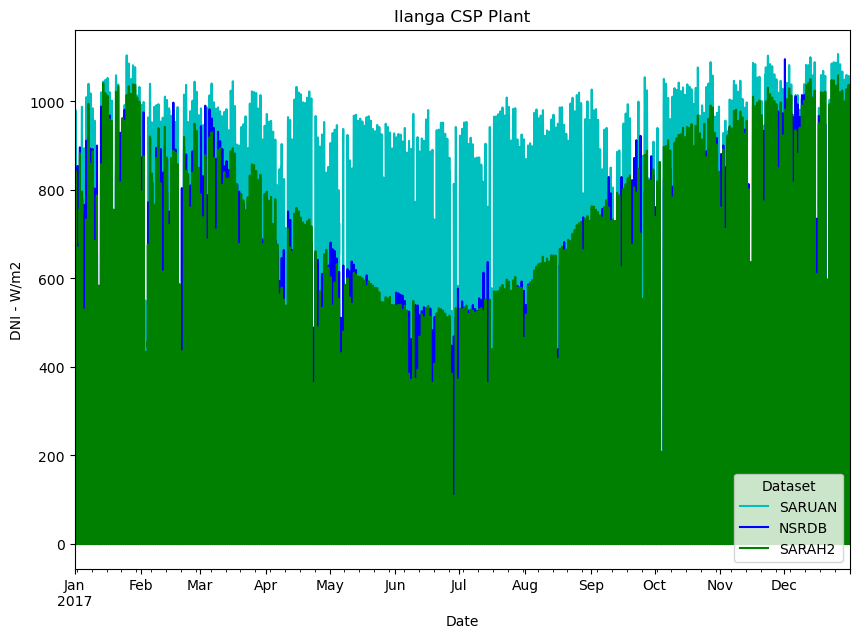

[False False False ... False False False]


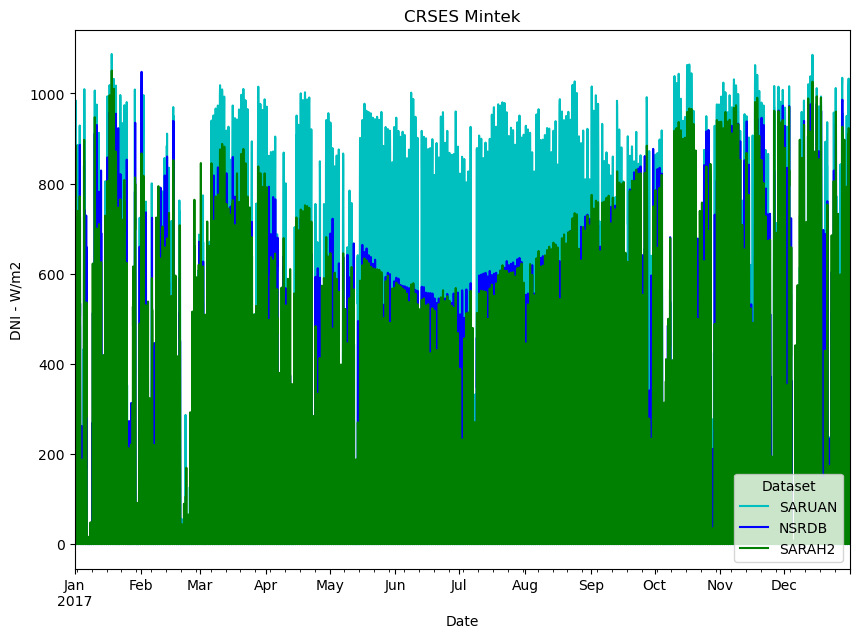

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming saruan_data, sarah2_data, and era5_data are dictionaries of DataFrames and var is the DataFrame with location names
plt.rc("figure", figsize=[10, 7])

# Loop over the keys in the 'var' DataFrame
for key in var.index:
    fig, ax = plt.subplots()
    
    # Boolean masks for the year 2017
    mask_2017_saruan = (saruan_data[key].index.year == 2017) if key in saruan_data else False

    nsrdb_1 = nsrdb_data[key]
    nsrdb_1.index = pd.to_datetime(nsrdb_1.index, format="%Y-%m-%d %H:%M:%S")
    mask_2017_nsrdb = (nsrdb_1.index.year == 2017) if key in nsrdb_data else False
    print(mask_2017_saruan)

    mask_2017_sarah2 = (sarah2_data[key].index.year == 2017) if key in sarah2_data else False
    mask_2017_era5 = (era5_data[key].index.year == 2017) if key in era5_data else False
    
    # Check if any data is available for the year 2017 for this key
    if mask_2017_saruan.any():
        saruan_data[key].loc[mask_2017_saruan, 'DNI'].plot(ax=ax, color='r', label='SARUAN')
    if mask_2017_nsrdb.any():
       nsrdb_1['dni'].resample('H').mean().plot(ax=ax, color='c', label='NSRDB')
    if mask_2017_sarah2.any():
        sarah2_data[key].loc[mask_2017_sarah2, 'Gb(i)'].plot(ax=ax, color='b', label='SARAH2')
    if mask_2017_era5.any():
        era5_data[key].loc[mask_2017_era5, 'Gb(i)'].plot(ax=ax, color='g', label='ERA5')

    # Set legend, labels, and title
    ax.legend(title='Dataset',loc='lower right',labels=['SARUAN', 'NSRDB','SARAH2', 'ERA5'])
    ax.set_xlabel('Date')
    ax.set_ylabel('DNI - W/m2')
    ax.set_title(var.loc[key, 'Name'] if key in var.index else key)

    # Show the plot if there's any data for 2017, otherwise close the figure
    if mask_2017_saruan.any() or mask_2017_nsrdb.any() or mask_2017_sarah2.any() or mask_2017_era5.any():
        plt.show()
    else:
        plt.close(fig)


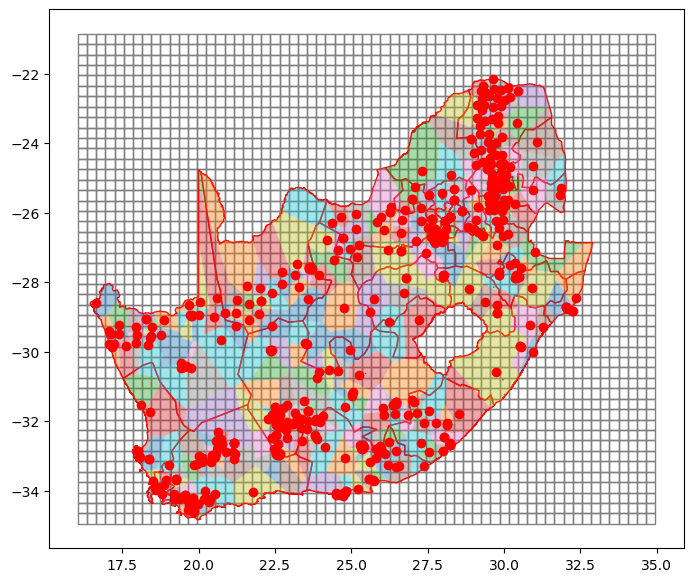

In [3]:
import matplotlib.pyplot as plt
from shapely.ops import voronoi_diagram
from shapely.geometry import MultiPoint, Point
import geopandas as gpd
import pandas as pd


points = pd.read_csv('wasa_gps.csv')
points = gpd.GeoSeries([Point(xy) for xy in zip(points['Longitude'], points['Latitude'])])
geom = MultiPoint(points)
voronoi_result = voronoi_diagram(geom, envelope=None, tolerance=0.0, edges=False)

clipped_voronoi = []
for cell in voronoi_result.geoms:  # Iterate through the geometries using .geoms
    if cell.is_empty:
        continue
    clipped_cell = cell.intersection(supply_30.unary_union)
    if not clipped_cell.is_empty:
        clipped_voronoi.append(clipped_cell)

plt.rc("figure", figsize=[10, 7])
fig, ax = plt.subplots()
cutout.grid.plot(ax=ax, edgecolor="grey", color="None")

supply_30 = gpd.read_file('../data/bundle/supply_regions/30-supply.shp')
supply_30.crs = 'EPSG:4326'
supply_30.plot(ax=ax, edgecolor="red", color="None")

for geometry in clipped_voronoi:
    # Check if geometry is a Polygon
    if geometry.geom_type == 'Polygon':
        x, y = geometry.exterior.xy
        ax.fill(x, y, alpha=0.4)
    # Check if geometry is a MultiPolygon
    elif geometry.geom_type == 'MultiPolygon':
        for polygon in geometry.geoms:
            x, y = polygon.exterior.xy
            ax.fill(x, y, alpha=0.4)

x_coords, y_coords = zip(*[(point.x, point.y) for point in points])
ax.scatter(x_coords, y_coords, color='red')


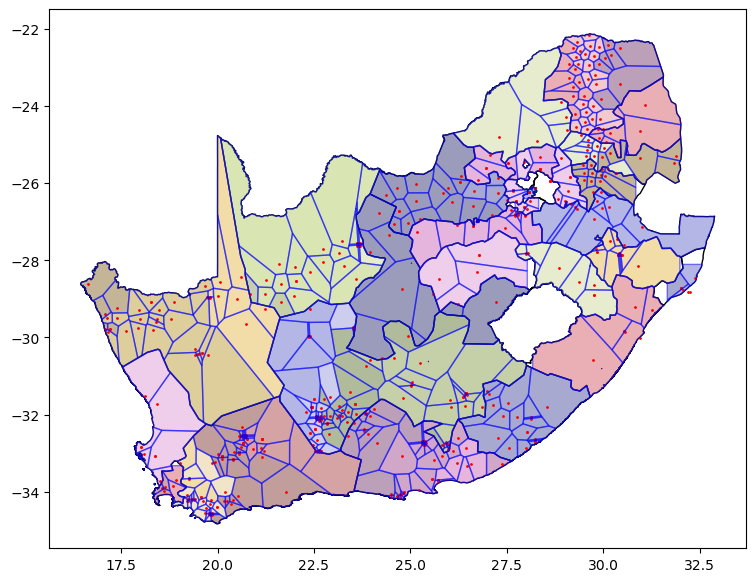

In [4]:
points = pd.read_csv('wasa_gps.csv')
gdf_points = gpd.GeoDataFrame(points, geometry=gpd.points_from_xy(points['Longitude'], points['Latitude']))

supply_30 = gpd.read_file('../data/bundle/supply_regions/30-supply.shp')
gdf_points = gdf_points.set_crs(supply_30.crs, allow_override=True)


all_voronoi_polygons = []

for supply_polygon in supply_30.geometry:
    within_points = gdf_points[gdf_points.within(supply_polygon)].reset_index(drop=True)
    
    if len(within_points) > 2:
        multipoint = MultiPoint(within_points.geometry)
        # Use a different name for the result to avoid overwriting the function
        voronoi_result = voronoi_diagram(multipoint)  # This should not raise an error now
        clipped_voronoi = [cell.intersection(supply_polygon) for cell in voronoi_result.geoms if not cell.is_empty]
        
        all_voronoi_polygons.extend(clipped_voronoi)

# Combine all the Voronoi cells into a single GeoDataFrame
voronoi_gdf = gpd.GeoDataFrame(geometry=all_voronoi_polygons)

# Now you can plot your Voronoi diagram with the 30_supply boundaries
fig, ax = plt.subplots(figsize=(10, 7))
supply_30.plot(ax=ax, color='None', edgecolor='black')
voronoi_gdf.plot(ax=ax, cmap='tab20b', alpha=0.5)
voronoi_gdf.boundary.plot(ax=ax, color='blue', linewidth=1, alpha=0.5)

x = gdf_points.geometry.x
y = gdf_points.geometry.y
ax.scatter(x, y, color='red', s=1)

plt.show()


In [5]:
import pandas as pd
import geopandas as gpd

hourly_wind_power = pd.read_csv('WASA_profiles.csv', index_col=0).loc['2017-01-01':'2017-12-31']
wasa_gps = pd.read_csv('wasa_gps.csv')

power_long = hourly_wind_power.reset_index().melt(id_vars='index', var_name='file_name', value_name='power')
power_long.rename(columns={'index': 'date_time'}, inplace=True)

points_gdf = gpd.GeoDataFrame(
    wasa_gps,
    geometry=gpd.points_from_xy(wasa_gps.Longitude, wasa_gps.Latitude),
    crs='EPSG:4326'
)
# power_points_gdf = points_gdf.merge(power_long, on='file_name')

# # # Assume `voronoi_gdf` is already created and has a 'voronoi_id' column
# # # Perform a spatial join between the points with power data and the Voronoi cells
# voronoi_gdf['voronoi_id'] = range(len(voronoi_gdf))

# power_voronoi_gdf = gpd.sjoin(power_points_gdf, voronoi_gdf, how='left', op='within')

# # Step 4: Aggregate the power data for each Voronoi cell
# # Assuming 'voronoi_id' is the column from voronoi_gdf that identifies each Voronoi cell
# hourly_power_by_voronoi = power_voronoi_gdf.groupby(['date_time', 'voronoi_id'])['power'].mean().reset_index()

# # Step 5: Map the aggregated power data back to the supply_30 geometries
# # This assumes that there is a corresponding 'supply_id' or similar in `supply_30` to link it to `voronoi_gdf`
# # You will need to calculate this linkage between supply_30 and voronoi_gdf beforehand

# # Assuming 'supply_id' in supply_30 and 'voronoi_id' in voronoi_gdf
# supply_30['hourly_wind_profile'] = None  # initialize the column

# for idx, supply_geom in supply_30.iterrows():
#     # Get the voronoi cells corresponding to this supply area
#     related_voronoi_ids = voronoi_gdf[voronoi_gdf['supply_id'] == supply_geom['supply_id']]['voronoi_id']
#     # Filter the hourly power data for these Voronoi cells
#     supply_geom_power = hourly_power_by_voronoi[hourly_power_by_voronoi['voronoi_id'].isin(related_voronoi_ids)]
#     # Assign the aggregated power data to the supply_30 geometry
#     supply_30.at[idx, 'hourly_wind_profile'] = supply_geom_power.groupby('date_time')['power'].mean().tolist()

# # Now `supply_30` has the hourly wind profiles for each geometry


: 

In [6]:
points_gdf

,geometry
0,"POLYGON ((23.91524 -27.24591, 23.66380 -27.186..."
1,"POLYGON ((23.91524 -27.24591, 24.61684 -28.041..."
2,"POLYGON ((23.91524 -27.24591, 24.47978 -26.996..."
3,"POLYGON ((26.37728 -29.20786, 26.39311 -29.213..."
4,"MULTIPOLYGON (((24.43999 -29.60883, 24.35233 -..."
...,...
435,"POLYGON ((28.68171 -25.75709, 28.66171 -25.647..."
436,"POLYGON ((28.95109 -26.31233, 28.87843 -26.597..."
437,"POLYGON ((28.95109 -26.31233, 29.57476 -26.493..."
438,"POLYGON ((28.81569 -25.97465, 28.81245 -25.969..."
